# WB89_380
Trey V. Wenger - December 2024

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.1.1+5.g571cab8.dirty


## Load the data

rms 12CN 0.005452432119031414
rms 13CN 0.0029468342287699194
12CN-1 600
12CN-2 499
13CN-1 372
13CN-2 93


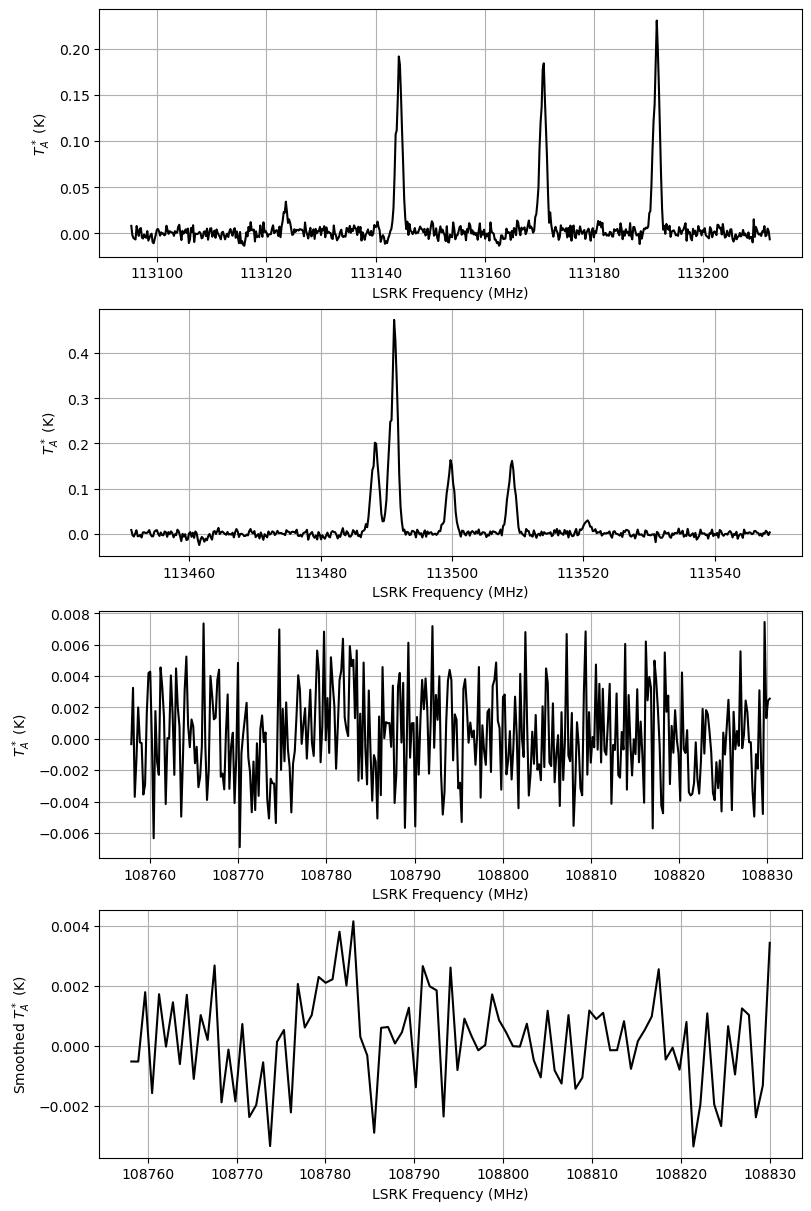

In [22]:
from bayes_spec import SpecData

data_12CN = np.genfromtxt("12CN_13CN_spectra/12CN_WB89_380_freq.dat")
data_13CN = np.genfromtxt("12CN_13CN_spectra/13CN_WB89_380_freq.dat")

# estimate noise
noise_12CN = 1.4826 * np.median(np.abs(data_12CN[:, 1] - np.median(data_12CN[:, 1])))
print("rms 12CN", noise_12CN)
noise_13CN = 1.4826 * np.median(np.abs(data_13CN[:, 1] - np.median(data_13CN[:, 1])))
print("rms 13CN", noise_13CN)

# boxcar smooth 13CN to 4 channels
data_13CN_smo_x = data_13CN[:, 0].reshape(93, 4).mean(axis=1)
data_13CN_smo = data_13CN[:, 1].reshape(93, 4).mean(axis=1)

obs_12CN_1 = SpecData(
    data_12CN[0:600, 0],
    data_12CN[0:600, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_A^*$ (K)",
)
obs_12CN_2 = SpecData(
    data_12CN[-500:-1, 0],
    data_12CN[-500:-1, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_A^*$ (K)",
)
obs_13CN_1 = SpecData(
    data_13CN[:, 0],
    data_13CN[:, 1],
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_A^*$ (K)",
)
obs_13CN_2 = SpecData(
    data_13CN_smo_x,
    data_13CN_smo,
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"Smoothed $T_A^*$ (K)",
)
data = {"12CN-1": obs_12CN_1, "12CN-2": obs_12CN_2, "13CN-1": obs_13CN_1, "13CN-2": obs_13CN_2}
for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# subset of 12CN data
data_12CN = {
    label: data[label]
    for label in data.keys() if "12CN" in label
}

# Plot the data
fig, axes = plt.subplots(len(data), layout="constrained", figsize=(8, 12))
for i, label in enumerate(data.keys()):
    axes[i].plot(data[label].spectral, data[label].brightness, 'k-')
    axes[i].set_xlabel(data[label].xlabel)
    axes[i].set_ylabel(data[label].ylabel)

## Reproduce Sun et al. (2024) model

In [23]:
import astropy.units as u
import astropy.constants as c
from bayes_cn_hfs.utils import supplement_mol_data
from bayes_cn_hfs.physics import calc_stat_weight

mol_data_12CN, weight_12CN = supplement_mol_data("CN")
print(mol_data_12CN)

sun2024_tau_ml = 0.58
sun2024_Tex = 4.34*u.K
freq = 113.5*u.GHz

# main line upper state column density
sun2024_Nu_ml = 8.0*np.pi*freq**2.0 / c.c**2.0 / (np.exp(c.h*freq/(c.k_B*sun2024_Tex)) - 1.0) / (mol_data_12CN["Aul"][5]/u.s) / (1.0/u.MHz) * sun2024_tau_ml
print("main line log10 upper column density", np.log10(sun2024_Nu_ml.to('cm-2').value))

# partition function
stat_weights = calc_stat_weight(mol_data_12CN["states"]["deg"], mol_data_12CN["states"]["E"], sun2024_Tex.to("K").value).eval()
Qtot = np.sum(stat_weights)

# total column density
sun2024_log10_Ntot = np.log10(Qtot/stat_weights[6] * sun2024_Nu_ml.to('cm-2').value)
print("log10 total column density", sun2024_log10_Ntot)

{'freq': array([113123.3687, 113144.19  , 113170.535 , 113191.325 , 113488.142 ,
       113490.985 , 113499.643 , 113508.934 , 113520.4215]), 'Aul': array([1.26969616e-06, 1.03939111e-05, 5.07869910e-06, 6.59525390e-06,
       6.64784064e-06, 1.17706070e-05, 1.04919208e-05, 5.12459350e-06,
       1.28243028e-06]), 'degu': array([2, 2, 4, 4, 4, 6, 2, 4, 2]), 'El': array([1.3905121e-19, 0.0000000e+00, 1.3905121e-19, 0.0000000e+00,
       1.3905121e-19, 0.0000000e+00, 1.3905121e-19, 0.0000000e+00,
       0.0000000e+00]), 'Eu': array([7.49702428e-16, 7.49701340e-16, 7.50014955e-16, 7.50013660e-16,
       7.52119441e-16, 7.51999228e-16, 7.52195648e-16, 7.52118159e-16,
       7.52194276e-16]), 'relative_int': array([0.01204699, 0.09860036, 0.09633376, 0.1250773 , 0.12574146,
       0.33394774, 0.09921527, 0.09691221, 0.01212491]), 'log10_Q_terms': array([0.40307694, 0.97433601]), 'Qu': ['1 0 1 1', '1 0 1 1', '1 0 1 2', '1 0 1 2', '1 0 2 2', '1 0 2 3', '1 0 2 1', '1 0 2 2', '1 0 2 1'], 'Ql': 


Tex
[[4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]]

tau
[[0.02095209]
 [0.17150941]
 [0.16750926]
 [0.21752014]
 [0.21834459]
 [0.58001127]
 [0.17227444]
 [0.16830736]
 [0.02105628]]

tau_total
[1.73748484]

TR
[[2.17718756]
 [2.17688599]
 [2.17650447]
 [2.17620343]
 [2.17190905]
 [2.17186795]
 [2.17174278]
 [2.17160848]
 [2.17144243]]


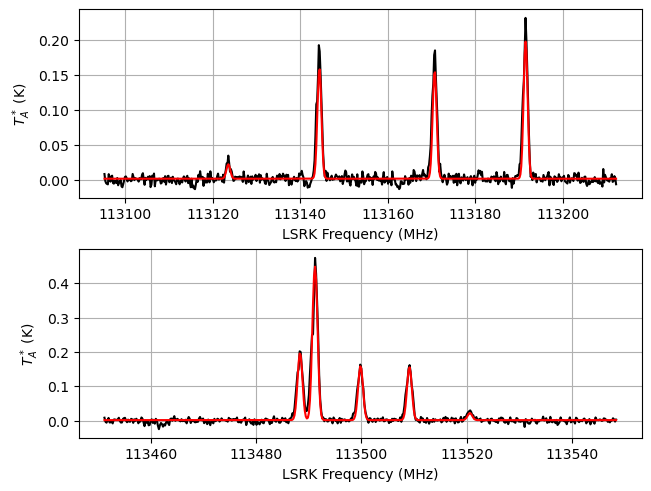

In [24]:
from bayes_cn_hfs.cn_model import CNModel

# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNModel(
    data_12CN,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = {label: 0.03 for label in data_12CN.keys()}, # width of spectral rms prior (K)
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = [0.75, 0.25], # ignored because LTE
    assume_CTEX = True, # implied because LTE
    prior_LTE_precision = 100.0, # ignored because LTE
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

# Simulate with Sun et al. (2024) parameters
# We choose values for velocity and FWHM that look good
sim_params = {
    "log10_N": [sun2024_log10_Ntot],
    "log10_Tkin": [np.log10(sun2024_Tex.to("K").value)],
    "fwhm_nonthermal": [2.75],
    "velocity": [-0.5],
    "fwhm_L": 0.0,
    "rms_12CN-1": 0.0,
    "rms_12CN-2": 0.0,
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
}
sim_obs = {label: model.model[label].eval(sim_params, on_unused_input="ignore") for label in data_12CN.keys()}

derived_params = ["Tex", "tau", "tau_total", "TR"]
derived_params = {
    param: model.model[param].eval(sim_params, on_unused_input="ignore")
    for param in derived_params
}

for key, value in derived_params.items():
    print()
    print(key)
    print(value)

# Plot the simulated data
fig, axes = plt.subplots(len(data_12CN), layout="constrained")
for i, label in enumerate(data_12CN.keys()):
    axes[i].plot(data_12CN[label].spectral, data_12CN[label].brightness, 'k-')
    axes[i].plot(data_12CN[label].spectral, sim_obs[label], 'r-')
    axes[i].set_xlabel(data_12CN[label].xlabel)
    axes[i].set_ylabel(data_12CN[label].ylabel)

This simulation is consistent with the Sun et al. (2024) model, but it is not a great fit to the data.


Tex_12CN
[[4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]]

tau_12CN
[[0.02095209]
 [0.17150941]
 [0.16750926]
 [0.21752014]
 [0.21834459]
 [0.58001127]
 [0.17227444]
 [0.16830736]
 [0.02105628]]

tau_total_12CN
[1.73748484]

TR_12CN
[[2.17718756]
 [2.17688599]
 [2.17650447]
 [2.17620343]
 [2.17190905]
 [2.17186795]
 [2.17174278]
 [2.17160848]
 [2.17144243]]

Tex_13CN
[[4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]
 [4.34]]

tau_13CN
[[8.49096422e-05]
 [1.10738266e-04]
 [4.31510496e-05]
 [1.91565453e-04]
 [1.15973686e-04]
 [3.10874638e-04]
 [3.58502816e-04]
 [1.19461214e-03]
 [2.38425575e-03]
 [1.21875226e-03]
 [3.66951781e-03]
 [1.36349057e-03]
 [1.61578847e-03]
 [1.21138738e-03]
 [1.04036596e-03]
 [6.22410759e-03]
 [4.56888613e-03]
 [1.26331788e-03]
 [9.28073027e-03]
 [4.89126590e-03]
 [2.164063

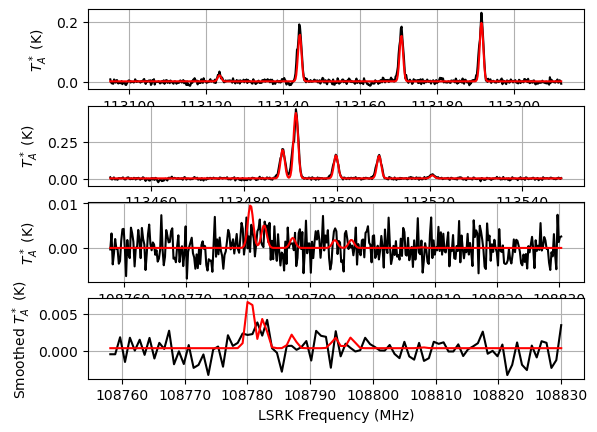

In [27]:
from bayes_cn_hfs import CNRatioModel

sun2024_ratio_12C_13C = 57.0

baseline_degree = 0
n_clouds = 1
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.8, 0.2], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = [0.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = {label: 0.03 for label in data.keys()}, # width of spectral rms prior (K)
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    prior_LTE_precision = 100.0, # ignored for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

# Simulate with Sun et al. (2024) parameters
# We choose values for velocity and FWHM that look good
sim_params = {
    "log10_N_12CN": [sun2024_log10_Ntot],
    "log10_Tkin": [np.log10(sun2024_Tex.to("K").value)],
    "fwhm_nonthermal": [2.75],
    "velocity": [-0.5],
    "fwhm_L": 0.0,
    "rms_12CN-1": 0.0,
    "rms_12CN-2": 0.0,
    "rms_13CN-1": 0.0,
    "rms_13CN-2": 0.0,
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
    "baseline_13CN-1_norm": [0.0],
    "baseline_13CN-2_norm": [0.0],
}
sim_obs = {key: model.model[key].eval(sim_params, on_unused_input="ignore") for key in data.keys()}

derived_params = ["Tex_12CN", "tau_12CN", "tau_total_12CN", "TR_12CN", "Tex_13CN", "tau_13CN", "tau_total_13CN", "TR_13CN",]
derived_params = {
    param: model.model[param].eval(sim_params, on_unused_input="ignore")
    for param in derived_params
}

for key, value in derived_params.items():
    print()
    print(key)
    print(value)

# Plot the simulated data
fig, axes = plt.subplots(len(data.keys()))
for ax, key in zip(axes, data.keys()):
    ax.plot(data[key].spectral, data[key].brightness, "k-")
    ax.plot(data[key].spectral, sim_obs[key], "r-")
    ax.set_xlabel(data[key].xlabel)
    ax.set_ylabel(data[key].ylabel)

## Ratio Model
We fix the kinetic temperature at the Sun et al. (2024) model value and assume LTE.

In [5]:
from bayes_cn_hfs import CNRatioModel

# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.8, 0.2], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    prior_LTE_precision = 100.0, # ignored for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    fix_log10_Tkin = np.log10(sun2024_Tex.to("K").value), # fix the kinetic (excitation) temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, 13CN, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, ratio_12C_13C, velocity_norm]


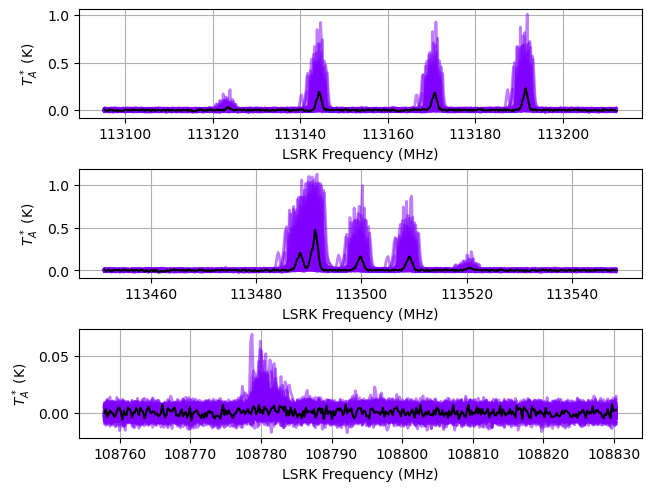

In [6]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [7]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 3000
Interrupted at 2,999 [2%]: Average Loss = -1,978.4


Output()

Runtime: 1.19 minutes


Sampling: [12CN-1, 12CN-2, 13CN]


Output()

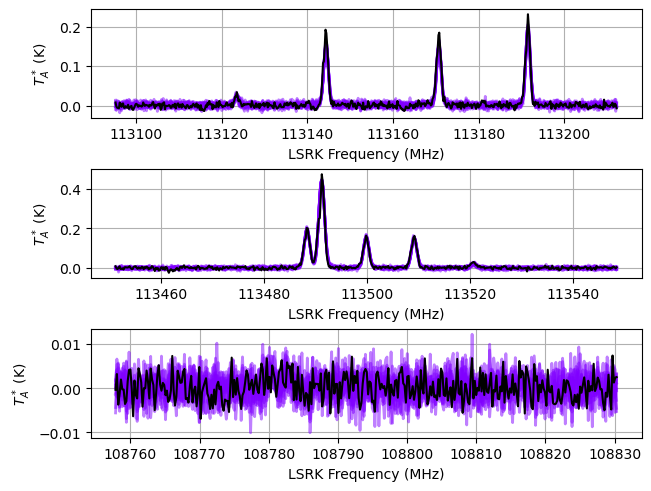

In [8]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [9]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3000
Interrupted at 2,999 [2%]: Average Loss = -1,978.4
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 85 seconds.


Adding log-likelihood to trace


Output()

Runtime: 2.90 minutes


In [10]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Sampling: [12CN-1, 12CN-2, 13CN]


Output()

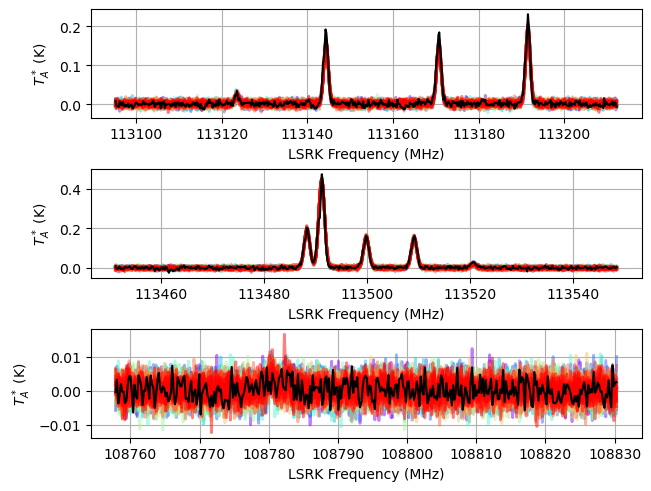

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [11]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs + ["ratio_12C_13C"])

solutions: [0]


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
velocity[0]             -4.750000e-01  8.000000e-03 -4.910000e-01   
fwhm_thermal_12CN[0]     8.700000e-02  0.000000e+00  8.700000e-02   
fwhm_thermal_13CN[0]     8.600000e-02  0.000000e+00  8.600000e-02   
fwhm_nonthermal[0]       3.143000e+00  3.300000e-02  3.084000e+00   
fwhm_12CN[0]             3.144000e+00  3.300000e-02  3.085000e+00   
fwhm_13CN[0]             3.144000e+00  3.300000e-02  3.085000e+00   
log10_N_12CN[0]          1.374500e+01  4.000000e-03  1.373800e+01   
N_13CN[0]                7.838118e+11  1.637247e+11  4.935367e+11   
log10_Tex_ul[0]          6.370000e-01  0.000000e+00  6.370000e-01   
tau_total_12CN[0]        2.094000e+00  1.700000e-02  2.063000e+00   
tau_total_13CN[0]        2.700000e-02  6.000000e-03  1.700000e-02   
fwhm_L                   4.000000e-01  6.800000e-02  2.660000e-01   
baseline_12CN-1_norm[0] -3.800000e-02  4.200000e-02 -1.170000e-01   
baseline_12CN-2_norm[0] -4.060000e-01  5.100000e-02 -5.010000e-01   
baseline_13CN_norm[0]    1.400000e-02  5.400000e-02 -8.400000e-02   
ratio_12C_13C[0]         7.418800e+01  1.682000e+01  4.776000e+01   

                              hdi_97%     mcse_mean       mcse_sd  ess_bulk  \
velocity[0]             -4.590000e-01  0.000000e+00  0.000000e+00    7869.0   
fwhm_thermal_12CN[0]     8.700000e-02  0.000000e+00  0.000000e+00    8000.0   
fwhm_thermal_13CN[0]     8.600000e-02  0.000000e+00  0.000000e+00    8000.0   
fwhm_nonthermal[0]       3.206000e+00  1.000000e-03  0.000000e+00    3891.0   
fwhm_12CN[0]             3.207000e+00  1.000000e-03  0.000000e+00    3891.0   
fwhm_13CN[0]             3.207000e+00  1.000000e-03  0.000000e+00    3891.0   
log10_N_12CN[0]          1.375100e+01  0.000000e+00  0.000000e+00    3582.0   
N_13CN[0]                1.098924e+12  1.831092e+09  1.294825e+09    7808.0   
log10_Tex_ul[0]          6.370000e-01  0.000000e+00  0.000000e+00    8000.0   
tau_total_12CN[0]        2.127000e+00  0.000000e+00  0.000000e+00    3582.0   
tau_total_13CN[0]        3.800000e-02  0.000000e+00  0.000000e+00    7808.0   
fwhm_L                   5.220000e-01  1.000000e-03  1.000000e-03    3122.0   
baseline_12CN-1_norm[0]  4.100000e-02  0.000000e+00  0.000000e+00    7762.0   
baseline_12CN-2_norm[0] -3.100000e-01  1.000000e-03  0.000000e+00    5945.0   
baseline_13CN_norm[0]    1.180000e-01  1.000000e-03  1.000000e-03    8019.0   
ratio_12C_13C[0]         1.057690e+02  2.040000e-01  1.520000e-01    7803.0   

                         ess_tail  r_hat  
velocity[0]                5985.0    1.0  
fwhm_thermal_12CN[0]       8000.0    NaN  
fwhm_thermal_13CN[0]       8000.0    NaN  
fwhm_nonthermal[0]         5143.0    1.0  
fwhm_12CN[0]               5143.0    1.0  
fwhm_13CN[0]               5143.0    1.0  
log10_N_12CN[0]            5453.0    1.0  
N_13CN[0]                  5162.0    1.0  
log10_Tex_ul[0]            8000.0    NaN  
tau_total_12CN[0]          5453.0    1.0  
tau_total_13CN[0]          5162.0    1.0  
fwhm_L                     4073.0    1.0  
baseline_12CN-1_norm[0]    5910.0    1.0  
baseline_12CN-2_norm[0]    5632.0    1.0  
baseline_13CN_norm[0]      5830.0    1.0  
ratio_12C_13C[0]           5137.0    1.0

We find a slightly larger $^{12}{\rm C}/^{13}{\rm C}$ ratio: $74 \pm 17$ compared to Sun et al. (2024) who found $57 \pm 17$ using the traditional HfS method and $57 \pm 13$ using the satellite-line method.

## Single component LTE
Mimic Sun et al. (2024) analysis.

In [13]:
# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNModel(
    data_12CN,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.75, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = [0.75, 0.25], # ignored because LTE
    assume_CTEX = True, # implied because LTE
    prior_LTE_precision = 100.0, # ignored because LTE
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tkin_norm, velocity_norm]


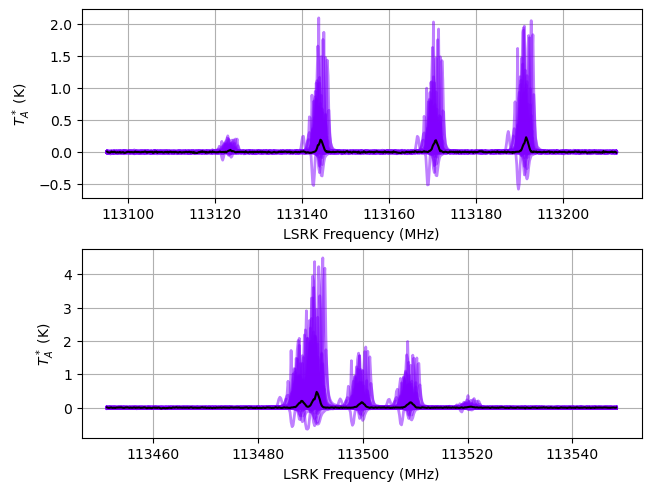

In [14]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [15]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 1,119


Output()

Runtime: 0.73 minutes


Sampling: [12CN-1, 12CN-2]


Output()

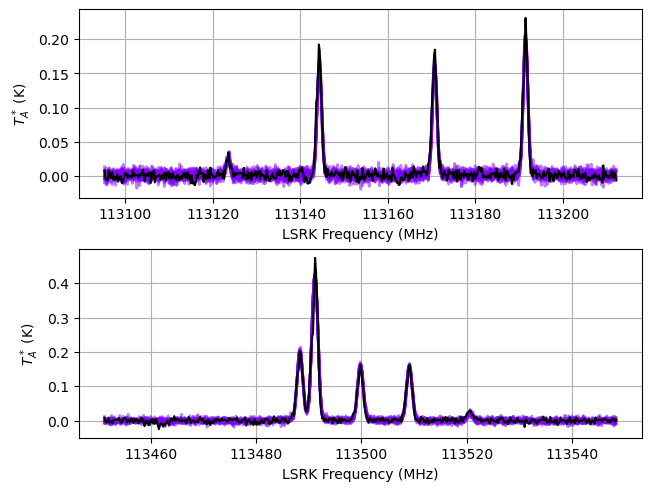

In [18]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [19]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
baseline_12CN-1_norm[0]  -0.074  0.043  -0.152    0.008      0.001    0.001   
baseline_12CN-2_norm[0]  -0.407  0.052  -0.502   -0.313      0.002    0.001   
velocity_norm[0]         -0.162  0.003  -0.168   -0.156      0.000    0.000   
log10_Tkin_norm[0]       -0.671  0.004  -0.679   -0.663      0.000    0.000   
log10_N_norm[0]           0.573  0.011   0.553    0.591      0.000    0.000   
fwhm_nonthermal_norm[0]   3.078  0.024   3.033    3.125      0.001    0.001   
fwhm_L_norm               0.357  0.026   0.305    0.402      0.001    0.001   
velocity[0]              -0.485  0.010  -0.503   -0.467      0.000    0.000   
log10_Tkin[0]             0.582  0.001   0.580    0.584      0.000    0.000   
fwhm_thermal[0]           0.082  0.000   0.082    0.082      0.000    0.000   
fwhm_nonthermal[0]        3.078  0.024   3.033    3.125      0.001    0.001   
fwhm[0]                   3.079  0.024   3.034    3.126      0.001    0.001   
fwhm_L                    0.357  0.026   0.305    0.402      0.001    0.001   
log10_N[0]               13.893  0.003  13.888   13.898      0.000    0.000   
log10_Tex_ul[0]           0.582  0.001   0.580    0.584      0.000    0.000   
Tex[113123.3687, 0]       3.822  0.010   3.804    3.839      0.000    0.000   
Tex[113144.19, 0]         3.822  0.010   3.804    3.839      0.000    0.000   
Tex[113170.535, 0]        3.822  0.010   3.804    3.839      0.000    0.000   
Tex[113191.325, 0]        3.822  0.010   3.804    3.839      0.000    0.000   
Tex[113488.142, 0]        3.822  0.010   3.804    3.839      0.000    0.000   
Tex[113490.985, 0]        3.822  0.010   3.804    3.839      0.000    0.000   
Tex[113499.643, 0]        3.822  0.010   3.804    3.839      0.000    0.000   
Tex[113508.934, 0]        3.822  0.010   3.804    3.839      0.000    0.000   
Tex[113520.4215, 0]       3.822  0.010   3.804    3.839      0.000    0.000   
tau[113123.3687, 0]       0.041  0.000   0.040    0.041      0.000    0.000   
tau[113144.19, 0]         0.333  0.002   0.329    0.338      0.000    0.000   
tau[113170.535, 0]        0.326  0.002   0.322    0.330      0.000    0.000   
tau[113191.325, 0]        0.423  0.003   0.418    0.428      0.000    0.000   
tau[113488.142, 0]        0.424  0.003   0.419    0.430      0.000    0.000   
tau[113490.985, 0]        1.127  0.008   1.114    1.142      0.000    0.000   
tau[113499.643, 0]        0.335  0.002   0.331    0.339      0.000    0.000   
tau[113508.934, 0]        0.327  0.002   0.323    0.331      0.000    0.000   
tau[113520.4215, 0]       0.041  0.000   0.040    0.041      0.000    0.000   
tau_total[0]              3.376  0.022   3.336    3.420      0.001    0.001   
TR[113123.3687, 0]        1.730  0.008   1.714    1.744      0.000    0.000   
TR[113144.19, 0]          1.729  0.008   1.714    1.744      0.000    0.000   
TR[113170.535, 0]         1.729  0.008   1.714    1.743      0.000    0.000   
TR[113191.325, 0]         1.729  0.008   1.713    1.743      0.000    0.000   
TR[113488.142, 0]         1.725  0.008   1.709    1.739      0.000    0.000   
TR[113490.985, 0]         1.725  0.008   1.709    1.739      0.000    0.000   
TR[113499.643, 0]         1.725  0.008   1.709    1.739      0.000    0.000   
TR[113508.934, 0]         1.724  0.008   1.709    1.739      0.000    0.000   
TR[113520.4215, 0]        1.724  0.008   1.709    1.739      0.000    0.000   

                         ess_bulk  ess_tail  r_hat  
baseline_12CN-1_norm[0]    1016.0     792.0    NaN  
baseline_12CN-2_norm[0]    1074.0    1052.0    NaN  
velocity_norm[0]           1009.0     592.0    NaN  
log10_Tkin_norm[0]          909.0     983.0    NaN  
log10_N_norm[0]             965.0    1021.0    NaN  
fwhm_nonthermal_norm[0]     972.0    1026.0    NaN  
fwhm_L_norm                 821.0     773.0    NaN  
velocity[0]                1009.0     592.0    NaN  
log10_Tkin[0]               909.0     983.0    NaN  
fwhm_thermal[0]     

In [20]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 1,119
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 108 seconds.


Adding log-likelihood to trace


Output()

Runtime: 3.41 minutes


In [21]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Sampling: [12CN-1, 12CN-2]


Output()

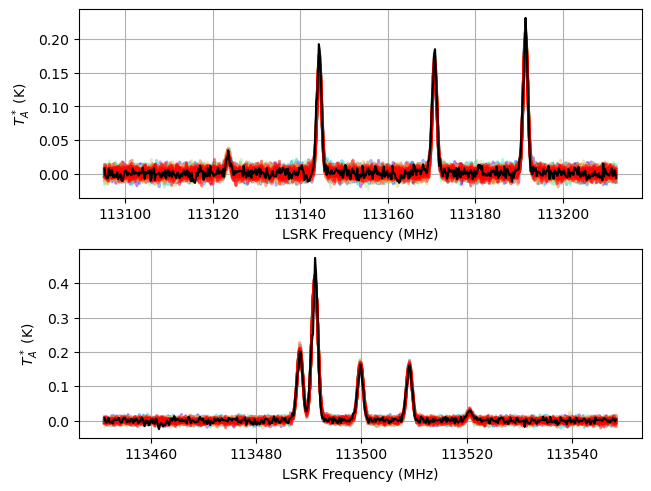

In [22]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [23]:
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics + model.hyper_freeRVs + model.baseline_freeRVs)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]              -0.460  0.009  -0.476   -0.444      0.000    0.000   
log10_Tkin[0]             0.568  0.003   0.562    0.573      0.000    0.000   
fwhm_thermal[0]           0.081  0.000   0.080    0.081      0.000    0.000   
fwhm_nonthermal[0]        3.038  0.032   2.979    3.101      0.000    0.000   
fwhm[0]                   3.039  0.032   2.980    3.102      0.000    0.000   
log10_N[0]               13.945  0.012  13.921   13.967      0.000    0.000   
log10_Tex_ul[0]           0.568  0.003   0.562    0.573      0.000    0.000   
Tex[113123.3687, 0]       3.698  0.026   3.647    3.745      0.000    0.000   
Tex[113144.19, 0]         3.698  0.026   3.647    3.745      0.000    0.000   
Tex[113170.535, 0]        3.698  0.026   3.647    3.745      0.000    0.000   
Tex[113191.325, 0]        3.698  0.026   3.647    3.745      0.000    0.000   
Tex[113488.142, 0]        3.698  0.026   3.647    3.745      0.000    0.000   
Tex[113490.985, 0]        3.698  0.026   3.647    3.745      0.000    0.000   
Tex[113499.643, 0]        3.698  0.026   3.647    3.745      0.000    0.000   
Tex[113508.934, 0]        3.698  0.026   3.647    3.745      0.000    0.000   
Tex[113520.4215, 0]       3.698  0.026   3.647    3.745      0.000    0.000   
tau[113123.3687, 0]       0.047  0.002   0.044    0.051      0.000    0.000   
tau[113144.19, 0]         0.389  0.014   0.363    0.415      0.000    0.000   
tau[113170.535, 0]        0.380  0.013   0.355    0.405      0.000    0.000   
tau[113191.325, 0]        0.493  0.017   0.461    0.526      0.000    0.000   
tau[113488.142, 0]        0.495  0.017   0.463    0.528      0.000    0.000   
tau[113490.985, 0]        1.314  0.046   1.229    1.404      0.001    0.000   
tau[113499.643, 0]        0.390  0.014   0.365    0.417      0.000    0.000   
tau[113508.934, 0]        0.381  0.013   0.357    0.407      0.000    0.000   
tau[113520.4215, 0]       0.048  0.002   0.045    0.051      0.000    0.000   
tau_total[0]              3.937  0.139   3.681    4.205      0.002    0.001   
TR[113123.3687, 0]        1.625  0.022   1.582    1.665      0.000    0.000   
TR[113144.19, 0]          1.624  0.022   1.582    1.664      0.000    0.000   
TR[113170.535, 0]         1.624  0.022   1.582    1.664      0.000    0.000   
TR[113191.325, 0]         1.624  0.022   1.582    1.664      0.000    0.000   
TR[113488.142, 0]         1.620  0.022   1.578    1.660      0.000    0.000   
TR[113490.985, 0]         1.620  0.022   1.578    1.660      0.000    0.000   
TR[113499.643, 0]         1.620  0.022   1.578    1.660      0.000    0.000   
TR[113508.934, 0]         1.620  0.022   1.577    1.660      0.000    0.000   
TR[113520.4215, 0]        1.619  0.022   1.577    1.660      0.000    0.000   
fwhm_L_norm               0.382  0.061   0.269    0.499      0.001    0.001   
baseline_12CN-1_norm[0]  -0.094  0.044  -0.173   -0.011      0.001    0.000   
baseline_12CN-2_norm[0]  -0.428  0.050  -0.522   -0.334      0.001    0.000   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                6494.0    5073.0    1.0  
log10_Tkin[0]              4675.0    4409.0    1.0  
fwhm_thermal[0]            4675.0    4409.0    1.0  
fwhm_nonthermal[0]         4382.0    5023.0    1.0  
fwhm[0]                    4382.0    5023.0    1.0  
log10_N[0]                 4620.0    4269.0    1.0  
log10_Tex_ul[0]            4675.0    4409.0    1.0  
Tex[113123.3687, 0]        4675.0    4409.0    1.0  
Tex[113144.19, 0]          4675.0    4409.0    1.0  
Tex[113170.535, 0]         4675.0    4409.0    1.0  
Tex[113191.325, 0]         4675.0    4409.0    1.0  
Tex[113488.142, 0]         4675.0    4409.0    1.0  
Tex[113490.985, 0]         4675.0    4409.0    1.0  
Tex[113499.643, 0]         4675.0    4409.0    1.0  
Tex[113508.934, 0]         4675.0    4409.0    1.0  
Tex[113520.4215, 0]        4675.0    4409.0    1.0  
tau[113123.3687, 0]        4613.0    4277.0 

['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


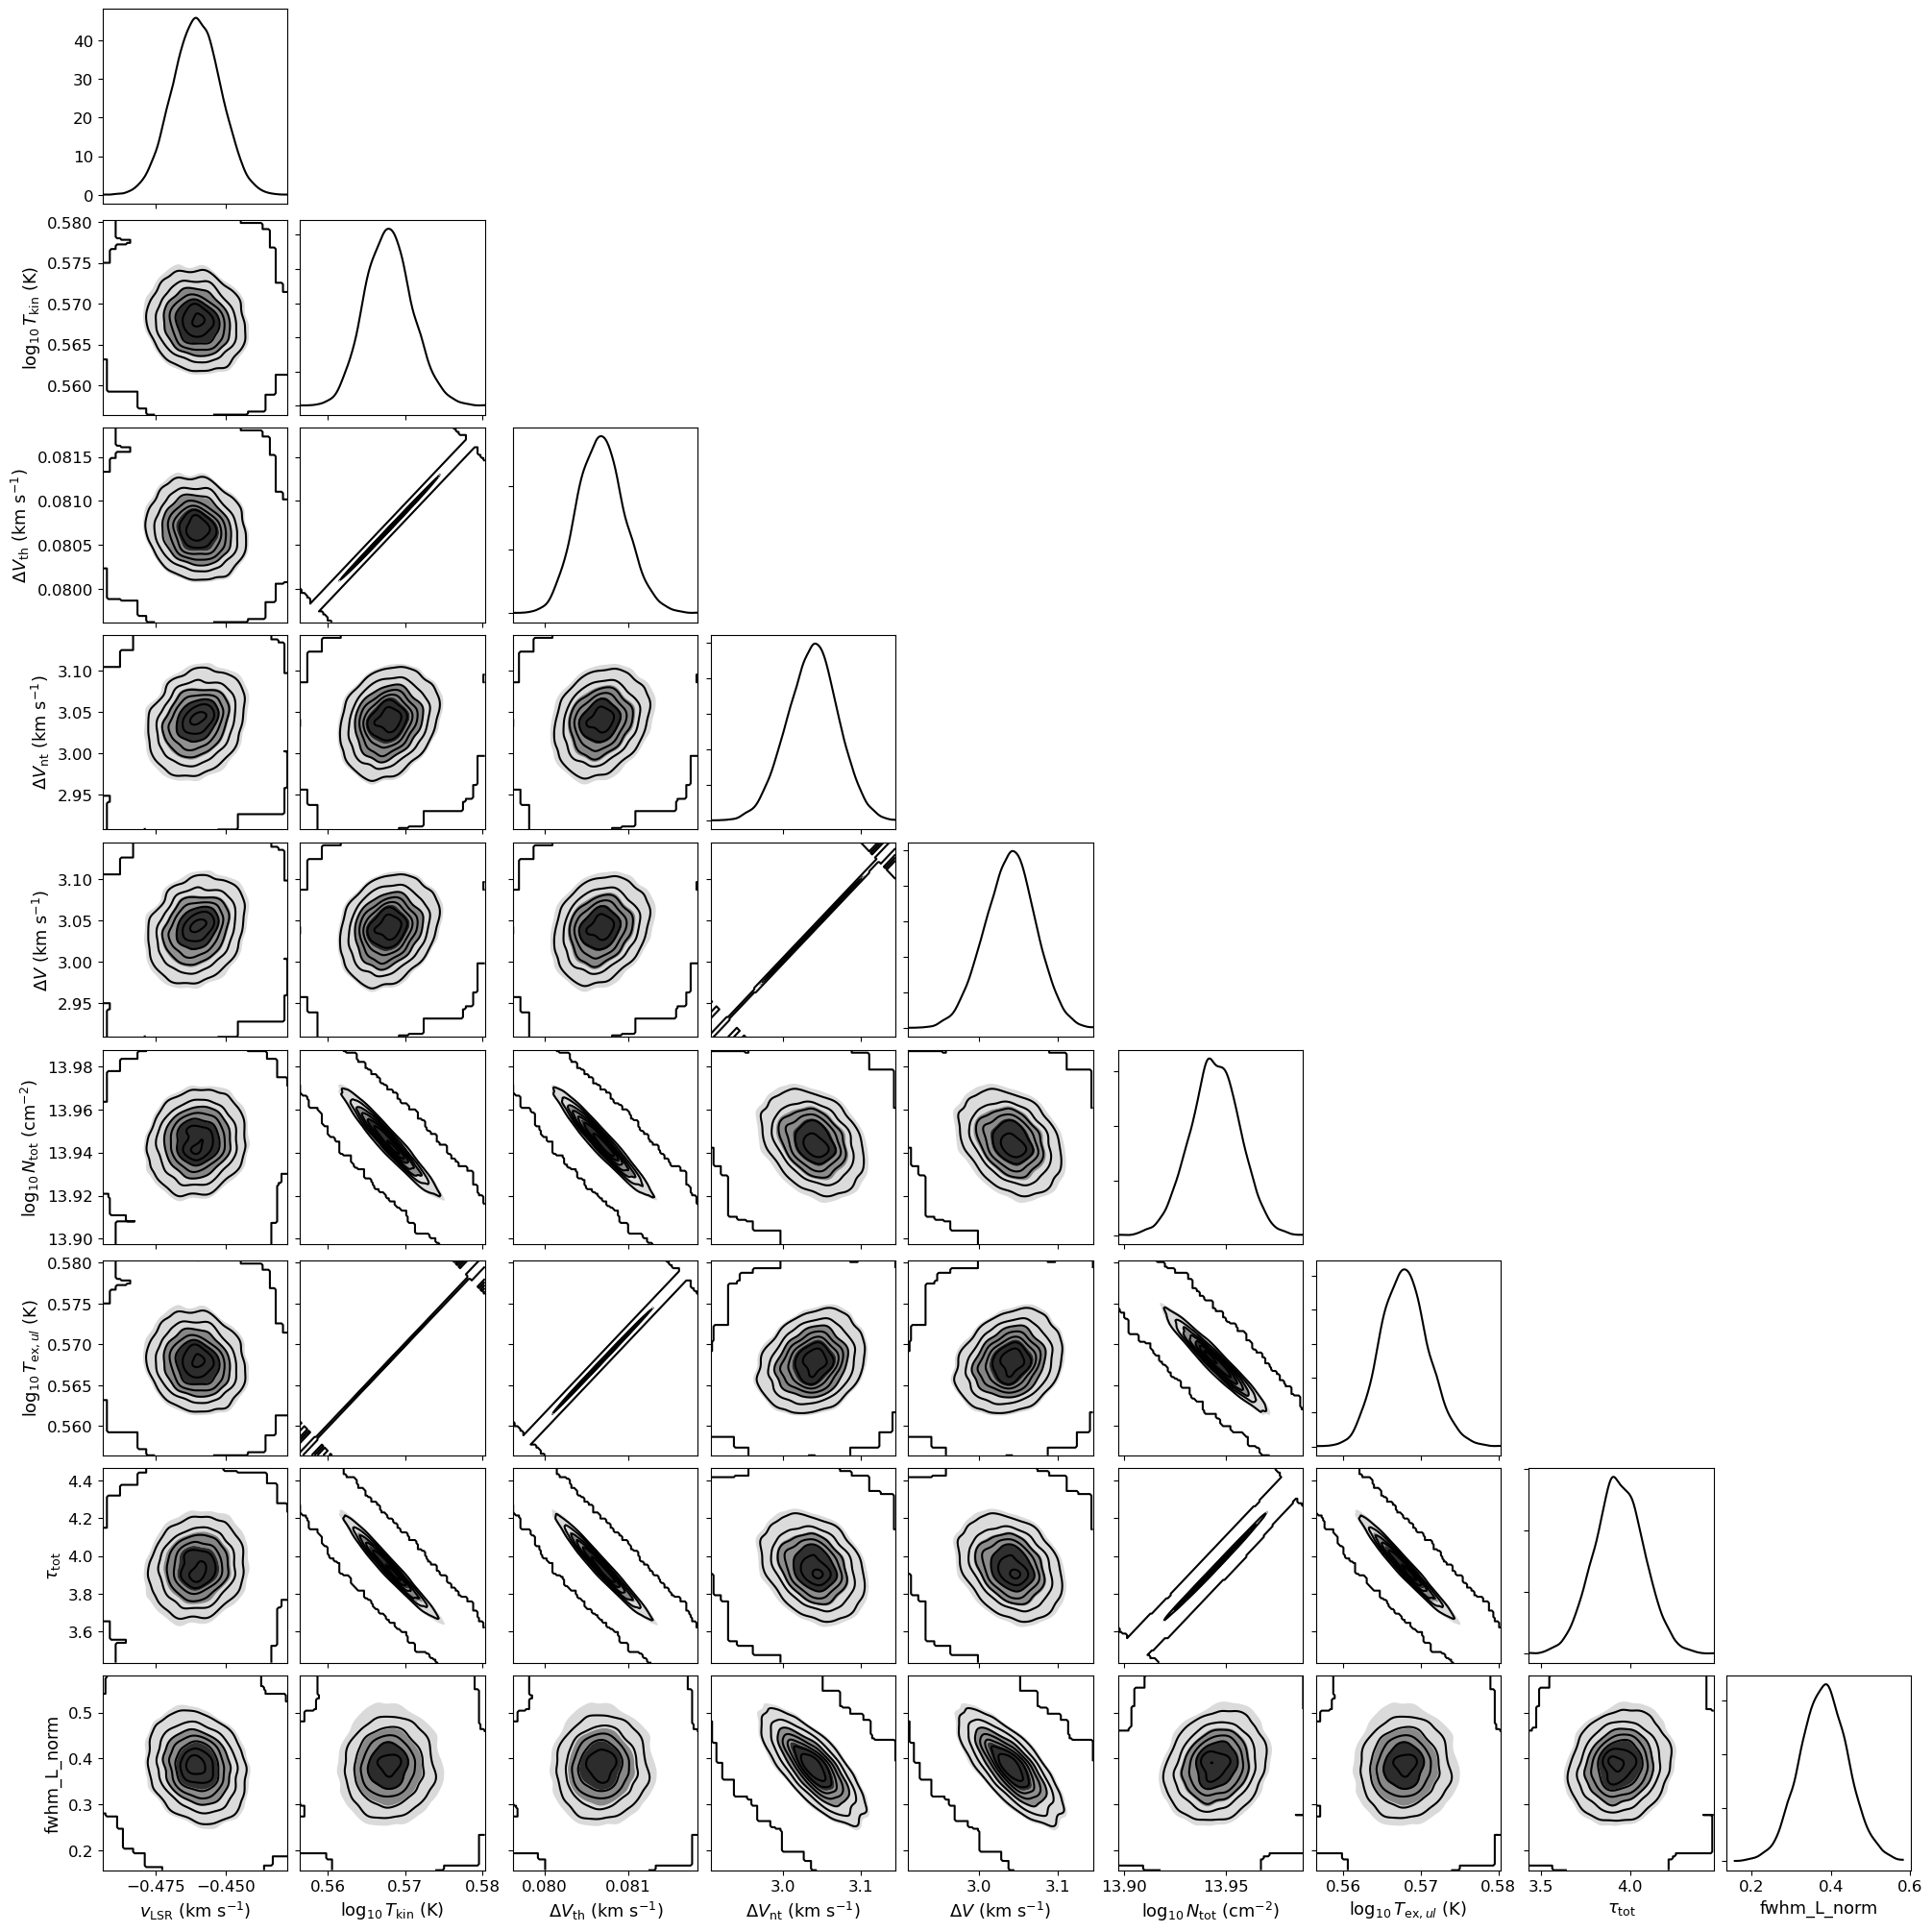

In [24]:
from bayes_spec.plots import plot_pair

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

We find a higher column density and optical depth, and smaller excitation temperature.

## Non-LTE model
Fix the kinetic temperature

In [25]:
# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNModel(
    data_12CN,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.75, 0.15], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.5, 0.15], # ignored because kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.15], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


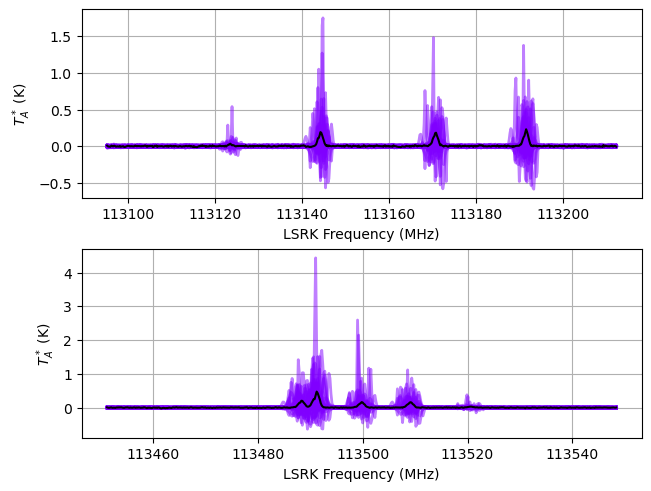

In [26]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [27]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5200
Interrupted at 5,199 [5%]: Average Loss = 73,035


Output()

Runtime: 0.56 minutes


Sampling: [12CN-1, 12CN-2]


Output()

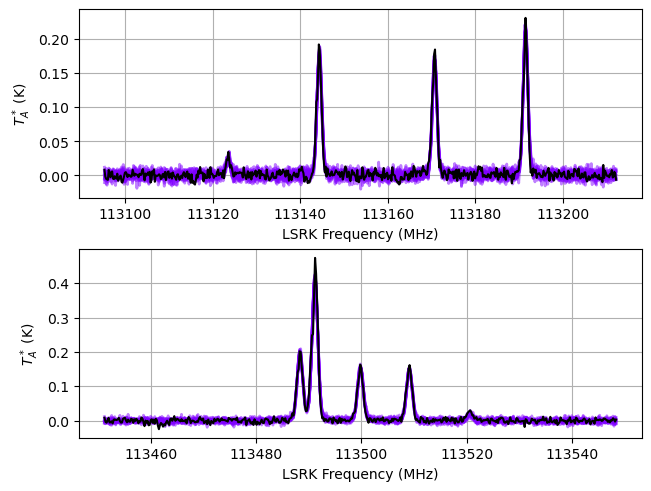

In [28]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [29]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5200
Interrupted at 5,199 [5%]: Average Loss = 73,035
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 674 seconds.


Adding log-likelihood to trace


Output()

There were 2 divergences in converged chains.
Runtime: 12.21 minutes


In [30]:
model.solve()

GMM converged to unique solution


Sampling: [12CN-1, 12CN-2]


Output()

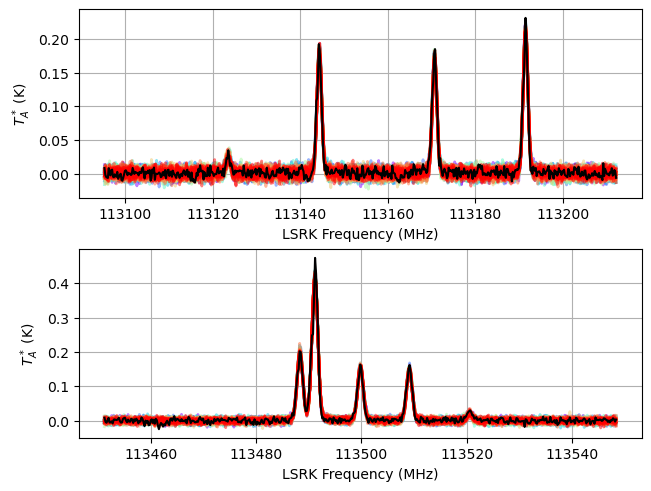

In [31]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [32]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    # if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "transition_free", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]              -0.474  0.009  -0.490   -0.457      0.000    0.000   
fwhm_thermal[0]           0.236  0.000   0.236    0.236      0.000    0.000   
fwhm_nonthermal[0]        3.193  0.042   3.113    3.269      0.001    0.001   
fwhm[0]                   3.201  0.041   3.122    3.277      0.001    0.001   
log10_N[0]               13.615  0.058  13.506   13.722      0.002    0.001   
log10_Tex_ul[0]           0.730  0.056   0.634    0.839      0.002    0.001   
Tex[113123.3687, 0]       6.375  1.192   4.710    8.460      0.036    0.026   
Tex[113144.19, 0]         6.078  0.964   4.628    7.800      0.030    0.021   
Tex[113170.535, 0]        6.072  1.024   4.556    7.859      0.031    0.022   
Tex[113191.325, 0]        5.806  0.841   4.521    7.330      0.026    0.018   
Tex[113488.142, 0]        5.643  0.834   4.400    7.156      0.026    0.018   
Tex[113490.985, 0]        5.066  0.516   4.263    6.037      0.016    0.011   
Tex[113499.643, 0]        5.587  0.814   4.390    7.093      0.025    0.018   
Tex[113508.934, 0]        5.418  0.696   4.339    6.687      0.021    0.015   
Tex[113520.4215, 0]       5.367  0.685   4.284    6.603      0.021    0.015   
tau[113123.3687, 0]       0.014  0.004   0.006    0.021      0.000    0.000   
tau[113144.19, 0]         0.118  0.032   0.059    0.176      0.001    0.001   
tau[113170.535, 0]        0.112  0.031   0.056    0.172      0.001    0.001   
tau[113191.325, 0]        0.154  0.040   0.081    0.229      0.001    0.001   
tau[113488.142, 0]        0.151  0.041   0.079    0.229      0.001    0.001   
tau[113490.985, 0]        0.440  0.104   0.246    0.634      0.003    0.002   
tau[113499.643, 0]        0.120  0.032   0.063    0.182      0.001    0.001   
tau[113508.934, 0]        0.123  0.031   0.067    0.181      0.001    0.001   
tau[113520.4215, 0]       0.016  0.004   0.008    0.023      0.000    0.000   
tau_total[0]              1.247  0.318   0.668    1.847      0.009    0.007   
TR[113123.3687, 0]        4.051  1.136   2.506    6.034      0.034    0.024   
TR[113144.19, 0]          3.770  0.912   2.432    5.398      0.028    0.020   
TR[113170.535, 0]         3.764  0.969   2.368    5.453      0.029    0.021   
TR[113191.325, 0]         3.514  0.789   2.335    4.944      0.024    0.017   
TR[113488.142, 0]         3.359  0.780   2.225    4.775      0.024    0.017   
TR[113490.985, 0]         2.825  0.473   2.104    3.718      0.015    0.010   
TR[113499.643, 0]         3.307  0.761   2.216    4.715      0.023    0.016   
TR[113508.934, 0]         3.149  0.646   2.170    4.329      0.020    0.014   
TR[113520.4215, 0]        3.103  0.635   2.122    4.250      0.019    0.014   
fwhm_L                    0.464  0.074   0.316    0.594      0.001    0.001   
baseline_12CN-1_norm[0]  -0.203  0.043  -0.284   -0.121      0.001    0.000   
baseline_12CN-2_norm[0]  -0.357  0.051  -0.452   -0.260      0.001    0.000   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                5765.0    4849.0   1.00  
fwhm_thermal[0]            8000.0    8000.0    NaN  
fwhm_nonthermal[0]         2205.0    3624.0   1.00  
fwhm[0]                    2205.0    3624.0   1.00  
log10_N[0]                 1118.0    1904.0   1.01  
log10_Tex_ul[0]            1446.0    2155.0   1.01  
Tex[113123.3687, 0]        1127.0    1820.0   1.01  
Tex[113144.19, 0]          1107.0    1760.0   1.01  
Tex[113170.535, 0]         1131.0    1819.0   1.01  
Tex[113191.325, 0]         1117.0    1768.0   1.01  
Tex[113488.142, 0]         1132.0    1814.0   1.01  
Tex[113490.985, 0]         1120.0    1783.0   1.01  
Tex[113499.643, 0]         1138.0    2022.0   1.01  
Tex[113508.934, 0]         1121.0    1887.0   1.01  
Tex[113520.4215, 0]        1137.0    1726.0   1.01  
tau[113123.3687, 0]        1124.0    1803.0   1.01  
tau[113144.19, 0]          1111.0    1776.0   1.01  
tau[113170.535, 0]         1125.0    1819.0   1.01  
tau[113191.325, 0

## Number of clouds

In [33]:
from bayes_spec import Optimize
from bayes_cn_hfs import CNModel

max_n_clouds = 5
baseline_degree = 0
opt = Optimize(
    CNModel,
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_log10_N = [13.75, 0.15], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.5, 0.15], # ignored because kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.15], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

Sampling: [12CN-1, 12CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


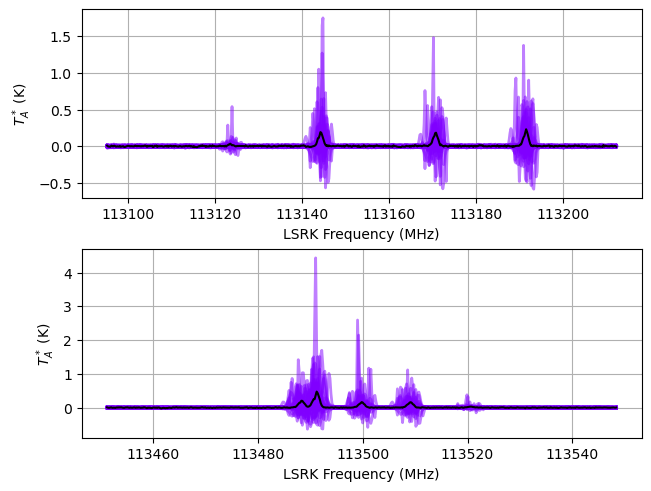

In [34]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = opt.models[1].sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(opt.models[1].data, prior.prior_predictive)

In [35]:
start = time.time()
fit_kwargs = {
    "n": 100_000,
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.01,
}
opt.fit_all(**fit_kwargs)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 5.117e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 5200
Interrupted at 5,199 [5%]: Average Loss = 73,035


Output()

n_cloud = 1 BIC = -7.349e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 5800
Interrupted at 5,799 [5%]: Average Loss = 50,432


Output()

n_cloud = 2 BIC = -7.743e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 6900
Interrupted at 6,899 [6%]: Average Loss = 1.3563e+05


Output()

n_cloud = 3 BIC = -7.791e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 7000
Interrupted at 6,999 [6%]: Average Loss = 1.5096e+06


Output()

n_cloud = 4 BIC = -7.771e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 7700
Interrupted at 7,699 [7%]: Average Loss = 1.2732e+06


Output()

n_cloud = 5 BIC = -7.762e+03

Runtime: 4.74 minutes


[51174.07284797 -7348.81728792 -7742.60391273 -7791.12611244
 -7770.71043819 -7761.63121105]


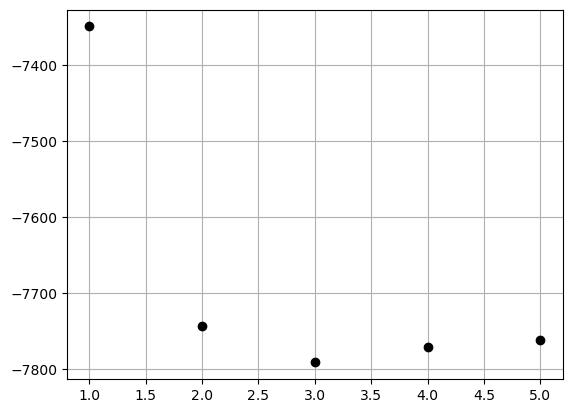

In [36]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
print(bics_vi)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko')

In [37]:
start = time.time()
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.01,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "n_init": 100_000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 5.117e+04
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5200
Interrupted at 5,199 [5%]: Average Loss = 73,035
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 676 seconds.


Adding log-likelihood to trace


Output()

There were 2 divergences in converged chains.
GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = -7.375e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5800
Interrupted at 5,799 [5%]: Average Loss = 50,432
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1528 seconds.


Adding log-likelihood to trace


Output()

There were 4 divergences in converged chains.
GMM converged to unique solution
7 of 8 chains appear converged.
n_cloud = 2 solution = 0 BIC = -8.070e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6900
Interrupted at 6,899 [6%]: Average Loss = 1.3563e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 4068 seconds.


Adding log-likelihood to trace


Output()

There were 1 divergences in converged chains.
GMM converged to unique solution
7 of 8 chains appear converged.
n_cloud = 3 solution = 0 BIC = -7.970e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7000
Interrupted at 6,999 [6%]: Average Loss = 1.5096e+06
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3173 seconds.


Adding log-likelihood to trace


Output()

There were 664 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7700
Interrupted at 7,699 [7%]: Average Loss = 1.2732e+06
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 6974 seconds.


Adding log-likelihood to trace


Output()

There were 1004 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Runtime: 280.76 minutes


No solutions. Try solve()
No solutions. Try solve()
[51174.07284797 -7375.07753668 -8069.70379559 -7970.16669676
            inf            inf]


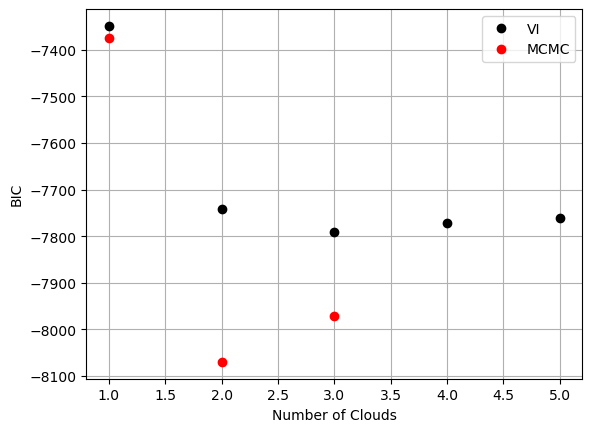

In [38]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_mcmc = np.array([null_bic] + [model.bic() for model in opt.models.values()])
print(bics_mcmc)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko', label="VI")
plt.plot(n_clouds[1:], bics_mcmc[1:], 'ro', label="MCMC")
plt.xlabel("Number of Clouds")
plt.ylabel("BIC")
_ = plt.legend()

[    0.         -7450.109876   -8204.76200636 -8165.25077898
            inf            inf]


/tmp/ipykernel_104131/3808025643.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ = plt.legend()


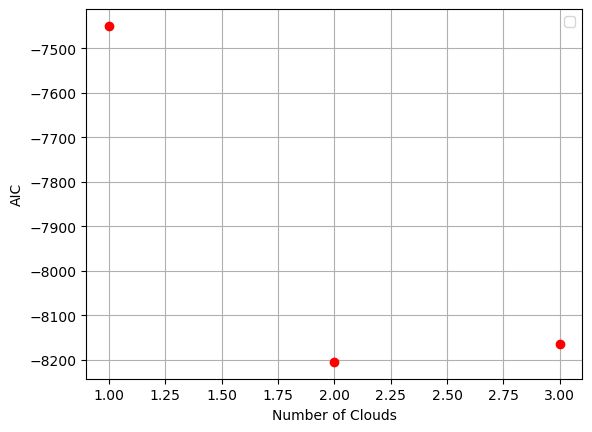

In [39]:
aics_mcmc = np.array([0.0] + [2.0*model._n_params - 2.0*model.mean_lnlike() if len(model.solutions) == 1 else np.inf for model in opt.models.values()])
print(aics_mcmc)

plt.plot(n_clouds[1:], aics_mcmc[1:], 'ro')
plt.xlabel("Number of Clouds")
plt.ylabel("AIC")
_ = plt.legend()

In [40]:
# model = opt.best_model
model = opt.models[2]
print(model.n_clouds)
model.solve()

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
]
pm.summary(model.trace.solution_0, var_names=var_names + ["LTE_precision"] + model.hyper_freeRVs + model.hyper_deterministics + model.baseline_freeRVs)

2
GMM converged to unique solution
7 of 8 chains appear converged.


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               0.551  0.042   0.473    0.630      0.001    0.001   
velocity[1]              -0.317  0.014  -0.343   -0.292      0.000    0.000   
fwhm_thermal[0]           0.236  0.000   0.236    0.236      0.000    0.000   
fwhm_thermal[1]           0.236  0.000   0.236    0.236      0.000    0.000   
fwhm_nonthermal[0]        0.925  0.095   0.742    1.099      0.002    0.001   
fwhm_nonthermal[1]        3.120  0.039   3.047    3.192      0.001    0.001   
fwhm[0]                   0.955  0.092   0.779    1.124      0.001    0.001   
fwhm[1]                   3.129  0.039   3.056    3.201      0.001    0.001   
log10_N[0]               13.473  0.113  13.257   13.683      0.003    0.002   
log10_N[1]               13.627  0.059  13.516   13.733      0.002    0.001   
log10_Tex_ul[0]           0.455  0.015   0.426    0.483      0.000    0.000   
log10_Tex_ul[1]           0.752  0.058   0.651    0.865      0.002    0.001   
Tex[113123.3687, 0]       2.824  0.054   2.717    2.915      0.001    0.001   
Tex[113123.3687, 1]       6.400  1.173   4.639    8.509      0.036    0.026   
Tex[113144.19, 0]         2.817  0.048   2.727    2.899      0.001    0.001   
Tex[113144.19, 1]         6.175  0.984   4.686    8.076      0.031    0.022   
Tex[113170.535, 0]        2.789  0.058   2.681    2.883      0.002    0.001   
Tex[113170.535, 1]        6.226  1.072   4.624    8.218      0.033    0.023   
Tex[113191.325, 0]        2.782  0.055   2.681    2.874      0.001    0.001   
Tex[113191.325, 1]        6.017  0.911   4.584    7.716      0.028    0.020   
Tex[113488.142, 0]        2.786  0.052   2.683    2.868      0.001    0.001   
Tex[113488.142, 1]        5.774  0.870   4.400    7.372      0.027    0.019   
Tex[113490.985, 0]        2.946  0.072   2.814    3.060      0.002    0.001   
Tex[113490.985, 1]        5.518  0.650   4.473    6.751      0.020    0.014   
Tex[113499.643, 0]        2.789  0.048   2.701    2.870      0.001    0.001   
Tex[113499.643, 1]        5.649  0.821   4.322    7.139      0.025    0.018   
Tex[113508.934, 0]        2.779  0.052   2.683    2.866      0.001    0.001   
Tex[113508.934, 1]        5.599  0.751   4.434    7.054      0.023    0.016   
Tex[113520.4215, 0]       2.783  0.052   2.683    2.870      0.001    0.001   
Tex[113520.4215, 1]       5.483  0.717   4.329    6.835      0.022    0.016   
tau[113123.3687, 0]       0.021  0.005   0.012    0.031      0.000    0.000   
tau[113123.3687, 1]       0.014  0.004   0.006    0.021      0.000    0.000   
tau[113144.19, 0]         0.176  0.043   0.094    0.251      0.001    0.001   
tau[113144.19, 1]         0.117  0.033   0.060    0.180      0.001    0.001   
tau[113170.535, 0]        0.171  0.041   0.096    0.247      0.001    0.001   
tau[113170.535, 1]        0.112  0.033   0.051    0.170      0.001    0.001   
tau[113191.325, 0]        0.224  0.054   0.121    0.320      0.001    0.001   
tau[113191.325, 1]        0.151  0.042   0.075    0.226      0.001    0.001   
tau[113488.142, 0]        0.223  0.054   0.124    0.321      0.001    0.001   
tau[113488.142, 1]        0.152  0.043   0.075    0.230      0.001    0.001   
tau[113490.985, 0]        0.585  0.140   0.323    0.838      0.003    0.002   
tau[113490.985, 1]        0.421  0.108   0.222    0.617      0.003    0.002   
tau[113499.643, 0]        0.176  0.043   0.096    0.252      0.001    0.001   
tau[113499.643, 1]        0.121  0.034   0.061    0.183      0.001    0.001   
tau[113508.934, 0]        0.173  0.042   0.094    0.248      0.001    0.001   
tau[113508.934, 1]        0.122  0.032   0.062    0.180      0.001    0.001   
tau[113520.4215, 0]       0.022  0.005   0.012    0.031      0.000    0.000   
tau[113520.4215, 1]       0.015  0.004   0.008    0.023      0.000    0.000   
tau_total[0]              1.772  0.427   0.968    2.536      0.010    0.007   
tau_total[1]              1.225  0.331   0.609    1.813      0.010    0.007  

Sampling: [12CN-1, 12CN-2]


Output()

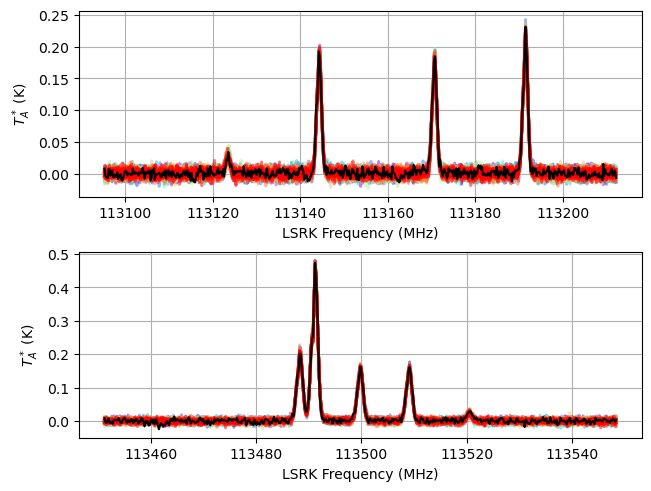

In [41]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

['velocity_norm', 'fwhm_nonthermal_norm', 'log10_N_norm', 'log10_Tex_ul_norm', 'LTE_precision', 'weights']


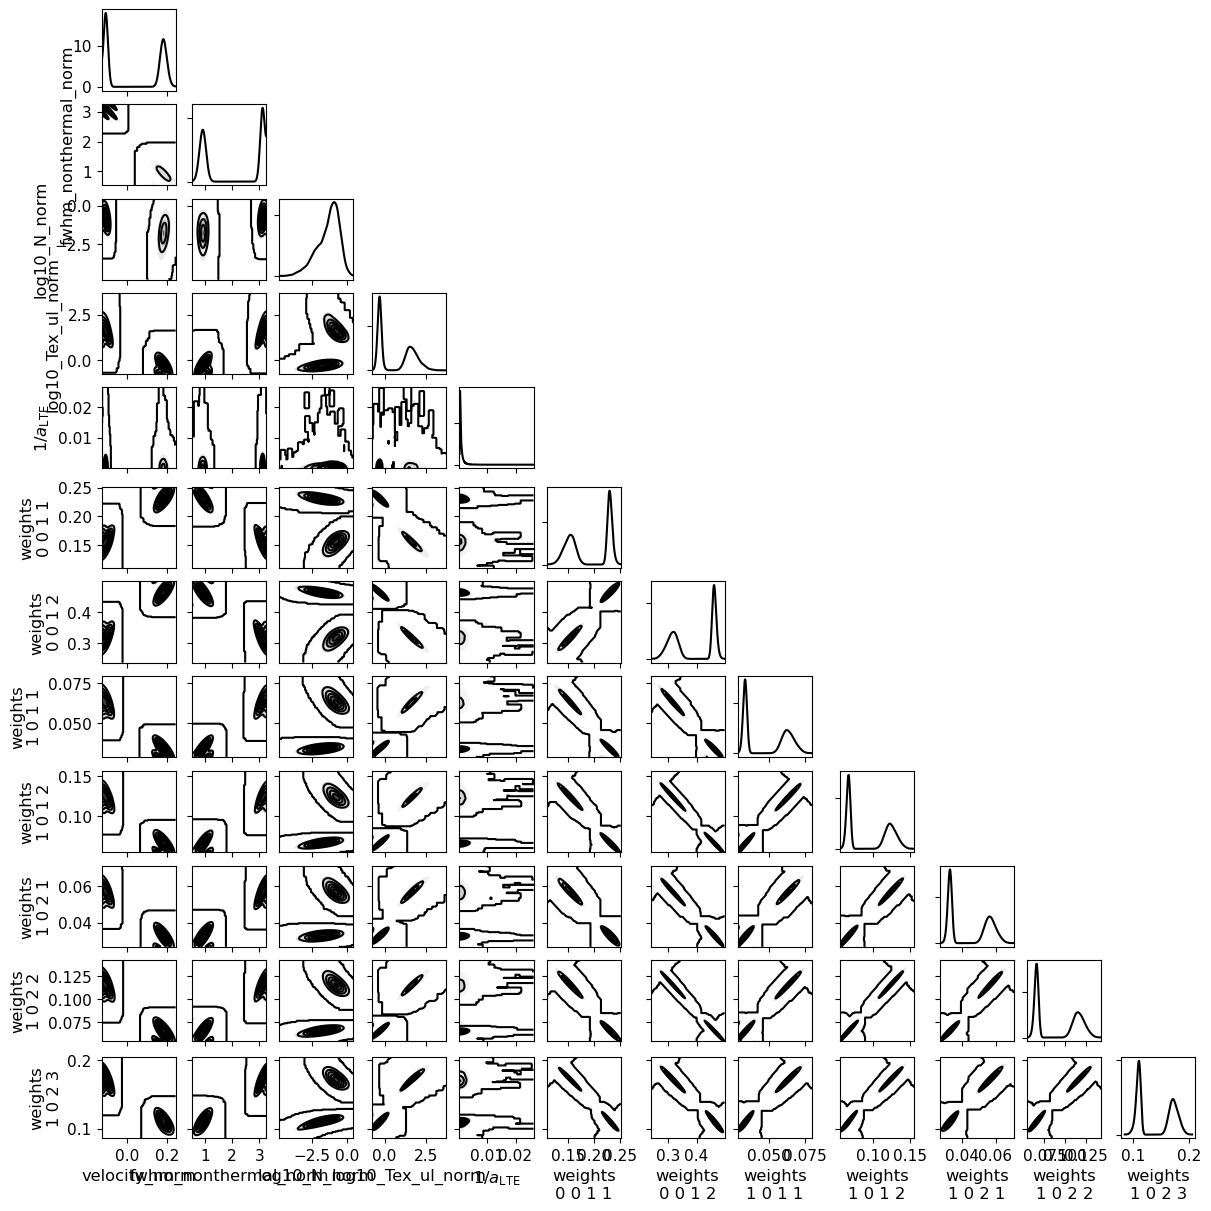

In [42]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
]
print(var_names)
axes = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.set_size_inches(12, 12)

['velocity', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


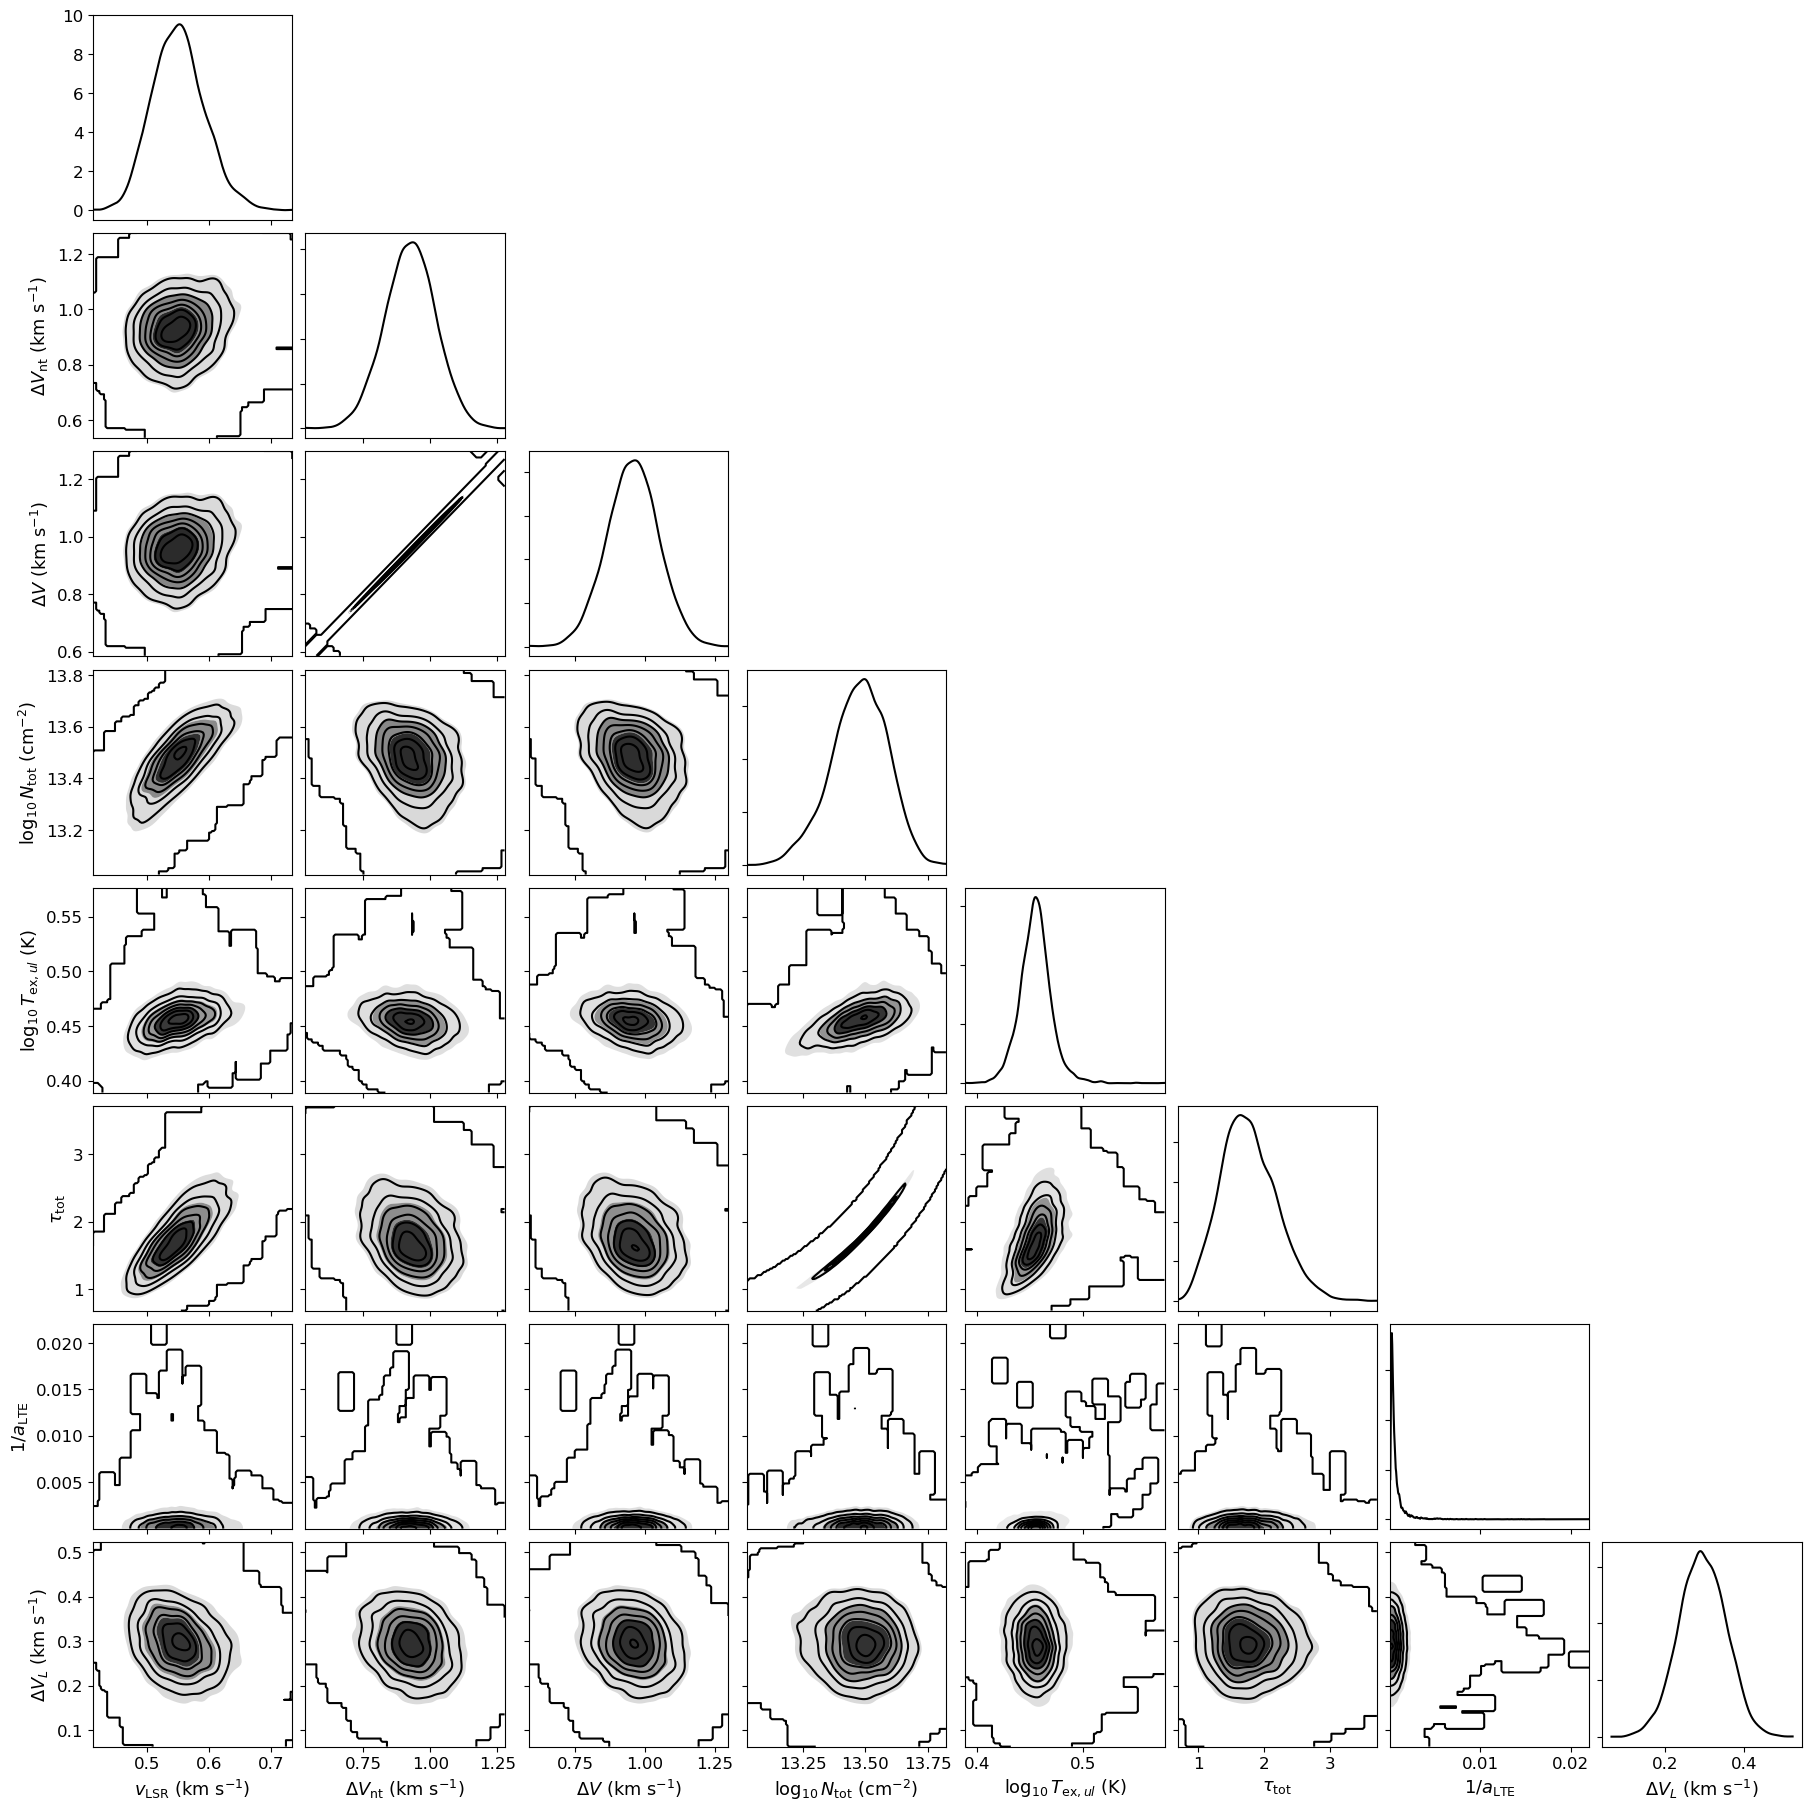

In [43]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
    and param not in ["fwhm_thermal"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + ["LTE_precision"] + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

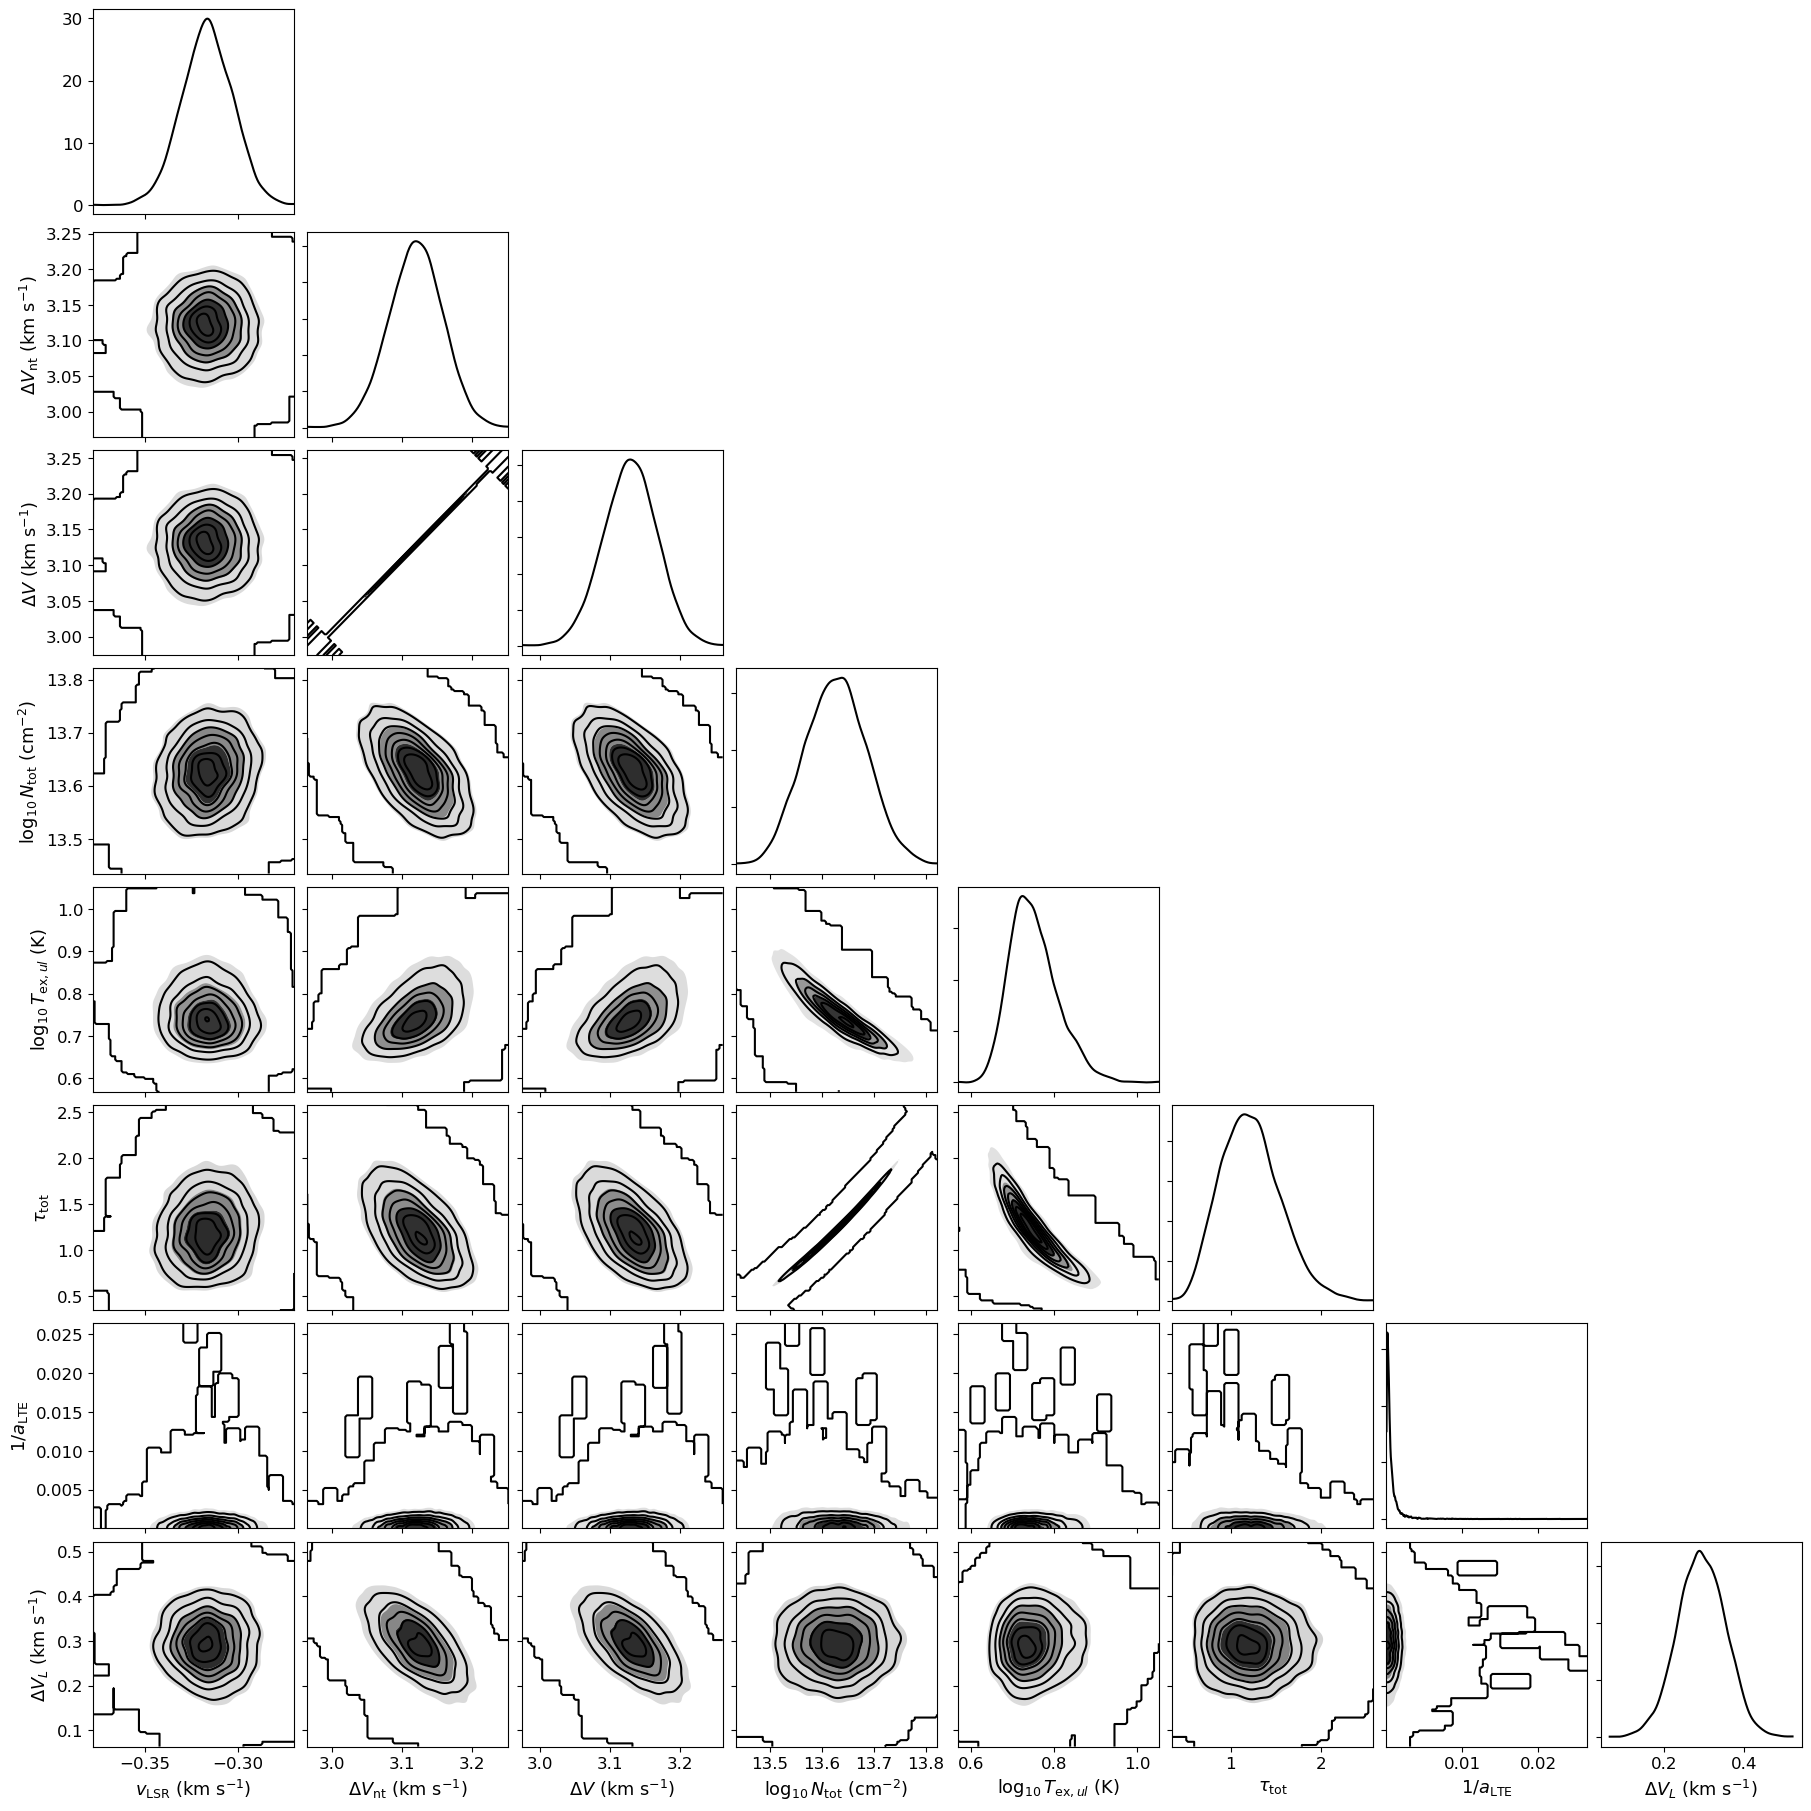

In [44]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + ["LTE_precision"] + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

## Ratio Model
We assume CTEX for 13CN.

In [46]:
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.50, 0.25], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.6, 0.15], # mean and width of excitation temperature prior (K)
    assume_CTEX_12CN = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    assume_CTEX_13CN = True, # assume CTEX for 13CN
    fix_log10_Tkin = 1.5, # kinetic temperature is fixed (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, 13CN, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tex_ul_norm, ratio_12C_13C, velocity_norm, weights_12CN]


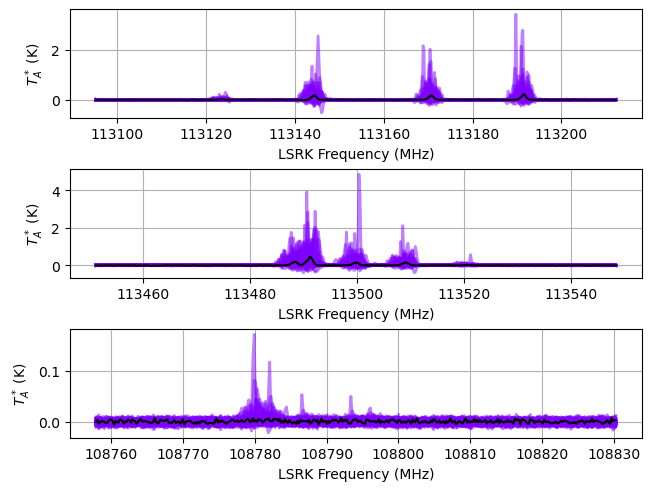

In [47]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [48]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 15,503


Output()

Runtime: 1.35 minutes


Sampling: [12CN-1, 12CN-2, 13CN]


Output()

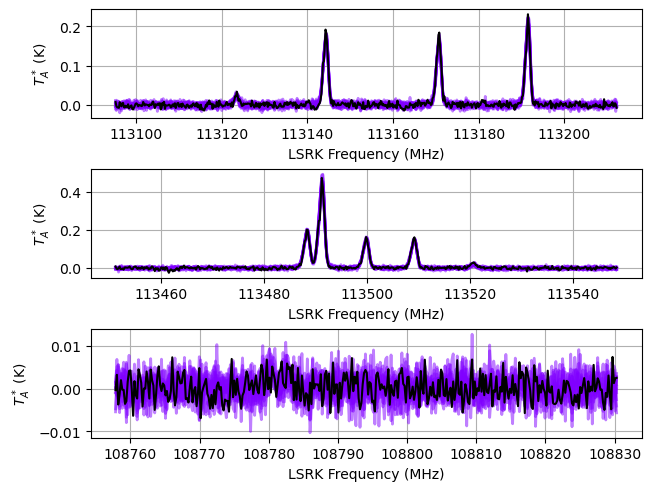

In [49]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [50]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 15,503
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C, log10_Tex_ul_norm, LTE_precision, weights_12CN]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3399 seconds.


Adding log-likelihood to trace


Output()

There were 1 divergences in converged chains.
Runtime: 58.65 minutes


In [51]:
model.solve(kl_div_threshold=0.1)

GMM found 2 unique solutions
Solution 0: chains [0, 2, 3, 4, 5, 6]
Solution 1: chains [1, 7]


In [52]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0, 1]


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
baseline_12CN-1_norm[0]  -1.810000e-01  4.200000e-02 -2.590000e-01   
baseline_12CN-2_norm[0]  -3.450000e-01  5.000000e-02 -4.370000e-01   
baseline_13CN_norm[0]     8.000000e-03  5.300000e-02 -8.800000e-02   
velocity_norm[0]         -2.690000e-01  6.000000e-03 -2.820000e-01   
velocity_norm[1]         -8.400000e-02  7.000000e-03 -9.600000e-02   
log10_N_12CN_norm[0]     -2.382000e+00  4.890000e-01 -3.295000e+00   
log10_N_12CN_norm[1]      3.536000e+00  1.680000e-01  3.224000e+00   
log10_Tex_ul_norm[0]      6.270000e-01  5.710000e-01 -3.460000e-01   
log10_Tex_ul_norm[1]     -7.710000e-01  4.200000e-02 -8.460000e-01   
fwhm_nonthermal_norm[0]   1.567000e+00  7.500000e-02  1.422000e+00   
fwhm_nonthermal_norm[1]   3.082000e+00  6.500000e-02  2.964000e+00   
fwhm_L_norm               1.890000e-01  4.700000e-02  1.010000e-01   
ratio_12C_13C[0]          6.556300e+01  2.520900e+01  2.604000e+01   
ratio_12C_13C[1]          1.018490e+02  2.366400e+01  6.081000e+01   
LTE_precision[0]          6.000000e-03  4.000000e-03  1.000000e-03   
LTE_precision[1]          0.000000e+00  0.000000e+00  0.000000e+00   
weights_12CN[0, 0 0 1 1]  1.650000e-01  2.000000e-02  1.280000e-01   
weights_12CN[0, 0 0 1 2]  3.250000e-01  3.600000e-02  2.560000e-01   
weights_12CN[0, 1 0 1 1]  4.700000e-02  5.000000e-03  3.800000e-02   
weights_12CN[0, 1 0 1 2]  1.100000e-01  1.200000e-02  9.000000e-02   
weights_12CN[0, 1 0 2 1]  4.600000e-02  5.000000e-03  3.600000e-02   
weights_12CN[0, 1 0 2 2]  9.800000e-02  9.000000e-03  8.200000e-02   
weights_12CN[0, 1 0 2 3]  2.090000e-01  2.500000e-02  1.660000e-01   
weights_12CN[1, 0 0 1 1]  2.210000e-01  1.000000e-03  2.180000e-01   
weights_12CN[1, 0 0 1 2]  4.430000e-01  2.000000e-03  4.390000e-01   
weights_12CN[1, 1 0 1 1]  3.800000e-02  1.000000e-03  3.700000e-02   
weights_12CN[1, 1 0 1 2]  7.500000e-02  1.000000e-03  7.400000e-02   
weights_12CN[1, 1 0 2 1]  3.600000e-02  0.000000e+00  3.600000e-02   
weights_12CN[1, 1 0 2 2]  7.300000e-02  1.000000e-03  7.200000e-02   
weights_12CN[1, 1 0 2 3]  1.140000e-01  1.000000e-03  1.120000e-01   
velocity[0]              -8.080000e-01  1.900000e-02 -8.460000e-01   
velocity[1]              -2.530000e-01  2.000000e-02 -2.880000e-01   
fwhm_thermal_12CN[0]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]        1.567000e+00  7.500000e-02  1.422000e+00   
fwhm_nonthermal[1]        3.082000e+00  6.500000e-02  2.964000e+00   
fwhm_12CN[0]              1.585000e+00  7.400000e-02  1.441000e+00   
fwhm_12CN[1]              3.091000e+00  6.400000e-02  2.973000e+00   
fwhm_13CN[0]              1.584000e+00  7.400000e-02  1.440000e+00   
fwhm_13CN[1]              3.090000e+00  6.400000e-02  2.973000e+00   
fwhm_L                    1.890000e-01  4.700000e-02  1.010000e-01   
log10_N_12CN[0]           1.290400e+01  1.220000e-01  1.267600e+01   
log10_N_12CN[1]           1.438400e+01  4.200000e-02  1.430600e+01   
N_13CN[0]                 1.455784e+11  6.921605e+10  4.240221e+10   
N_13CN[1]                 2.511788e+12  6.236147e+11  1.520469e+12   
log10_Tex_ul[0]           6.940000e-01  8.600000e-02  5.480000e-01   
log10_Tex_ul[1]           4.840000e-01  6.000000e-03  4.730000e-01   
Tex_12CN[113123.3687, 0]  4.517000e+00  2.439000e+00  3.233000e+00   
Tex_12CN[113123.3687, 1]  3.088000e+00  3.300000e-02  3.028000e+00   
Tex_12CN[113144.19, 0]    4.560000e+00  2.625000e+00  3.352000e+00   
Tex_12CN[113144.19, 1]    3.084000e+00  3.000000e-02  3.027000e+00   
Tex_12CN[113170.535, 0]   5.282000e+00  3.415000e+00  3.547000e+00   
Tex_12CN[113170.535, 1]   3.062000e+00  2.800000e-02  3.014000e+00   
Tex_12CN[113191.325, 0]   5.287000e+00  1.923000e+00  3.570000e+00   
Tex_12CN[113191.325, 1]   3.058000e+00  2.60

Sampling: [12CN-1, 12CN-2, 13CN]


Output()

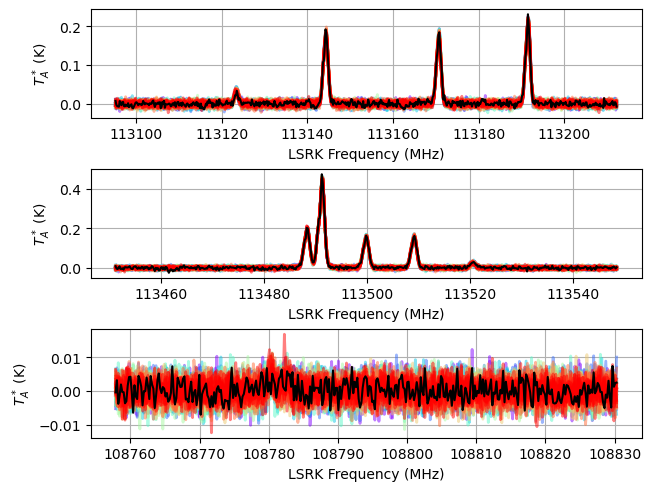

In [53]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [54]:
# 12C/13C ratio over all clouds
for solution in model.solutions:
    model.trace[f"solution_{solution}"]["ratio_12C_13C_total"] = (
        (10.0**model.trace[f"solution_{solution}"]["log10_N_12CN"]).sum(dim="cloud") / 
    model.trace[f"solution_{solution}"]["N_13CN"].sum(dim="cloud")
    )
    

In [55]:
pm.summary(model.trace.solution_0, var_names=["ratio_12C_13C_total"])

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
ratio_12C_13C_total  98.85  21.158  63.583  140.523      0.301    0.215   

                     ess_bulk  ess_tail  r_hat  
ratio_12C_13C_total    4964.0    4081.0    1.0

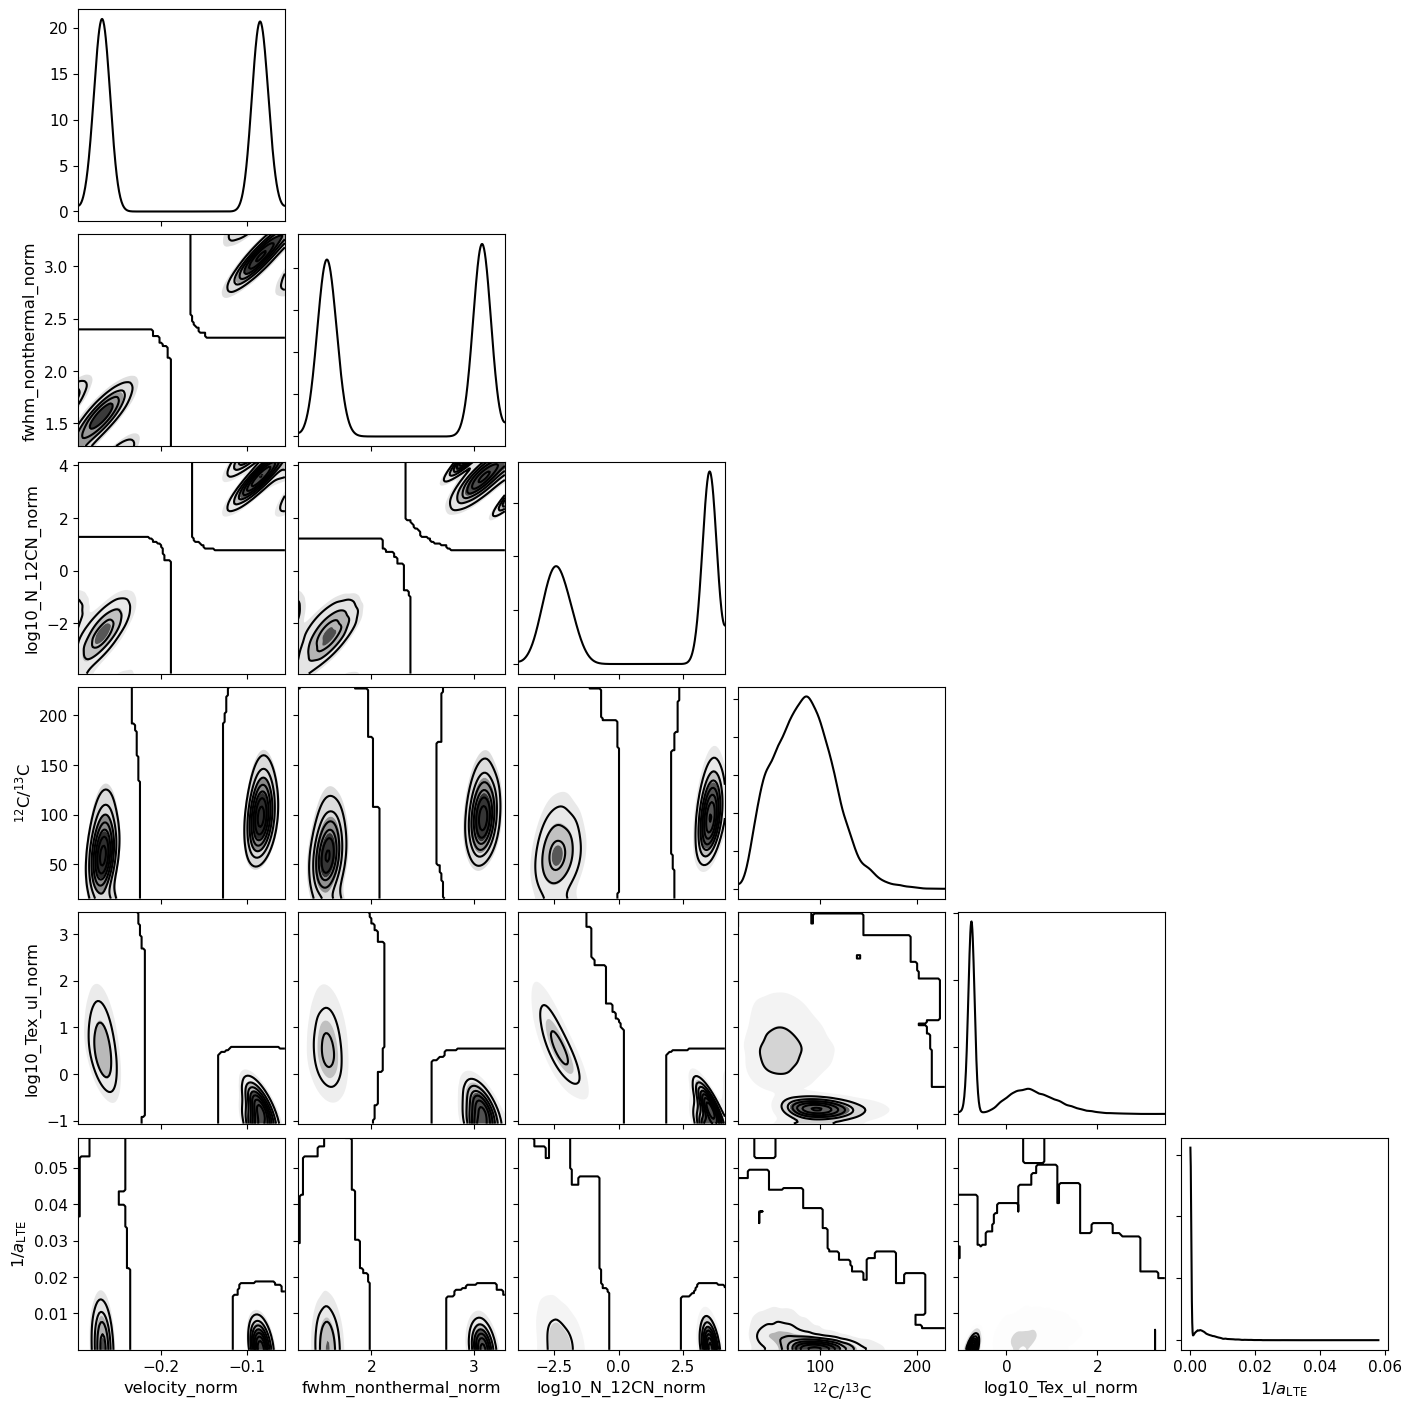

In [56]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [57]:
import pickle
with open("/staging/twenger2/wb89_380_trace.pkl", "wb") as f:
    pickle.dump(model.trace, f)

['velocity', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'tau_total_12CN', 'tau_total_13CN', 'ratio_12C_13C']


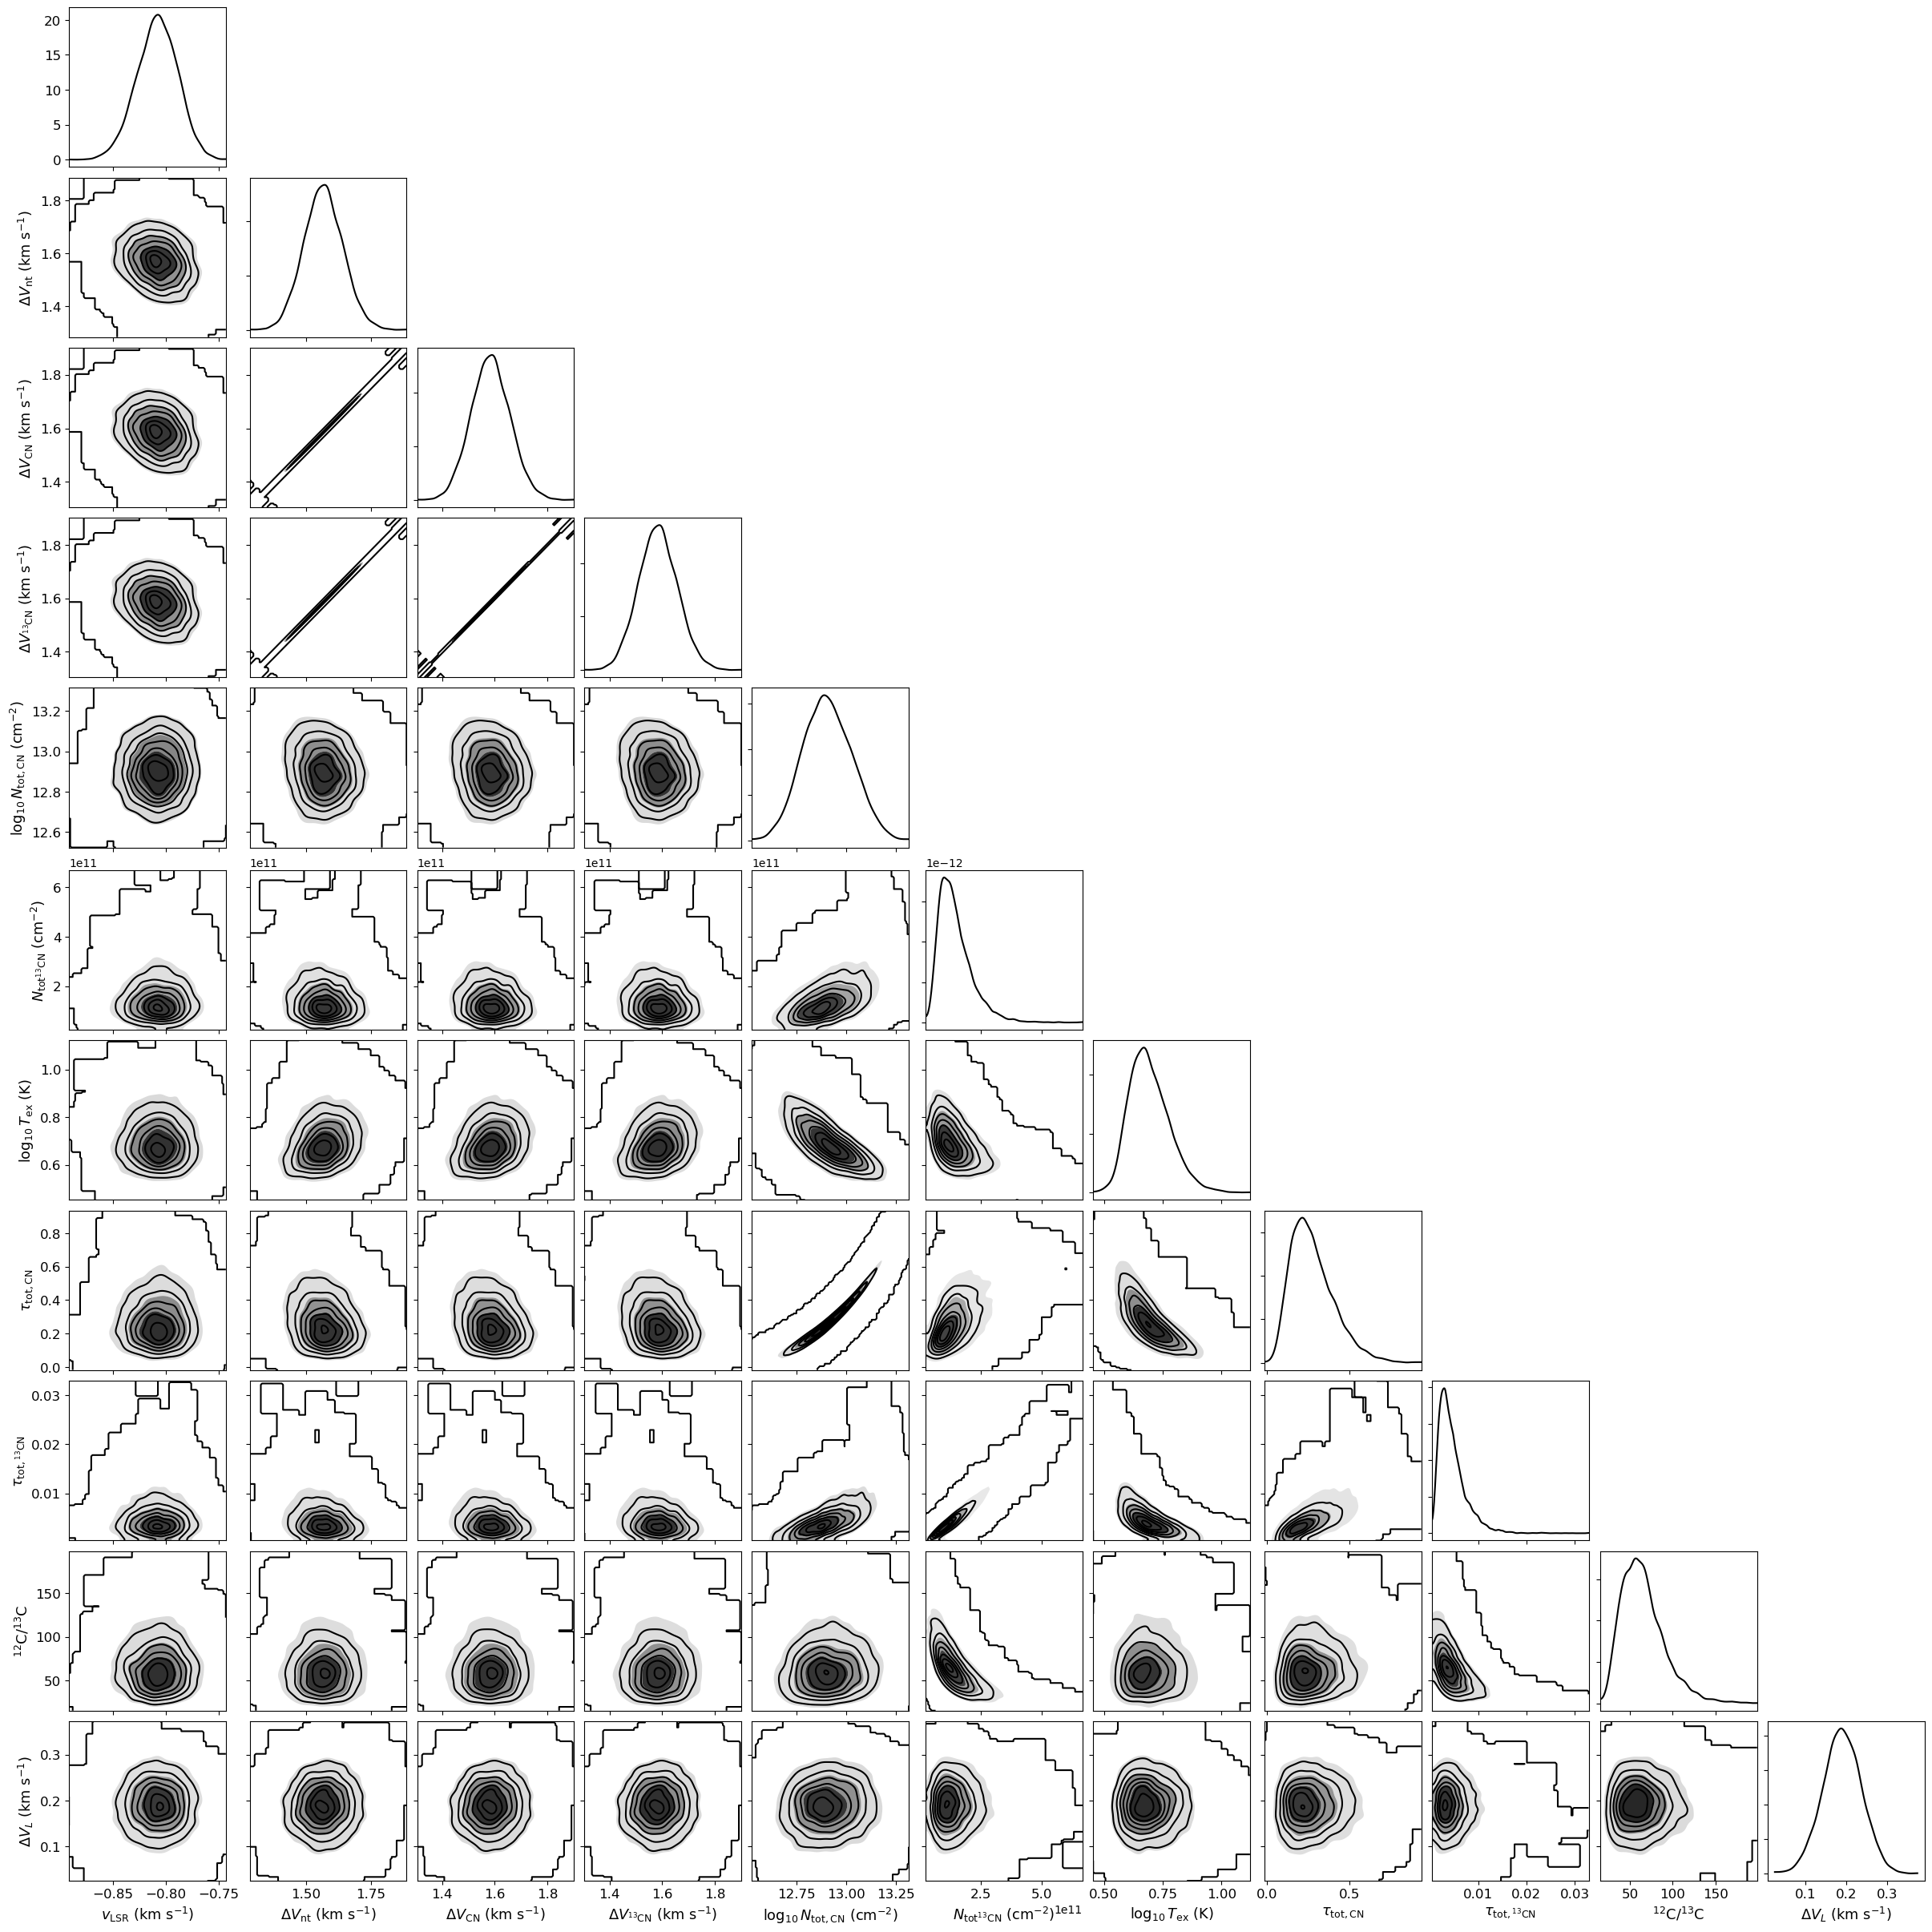

In [58]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics + ["ratio_12C_13C"]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    )) and param not in ["fwhm_thermal_12CN", "fwhm_thermal_13CN"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

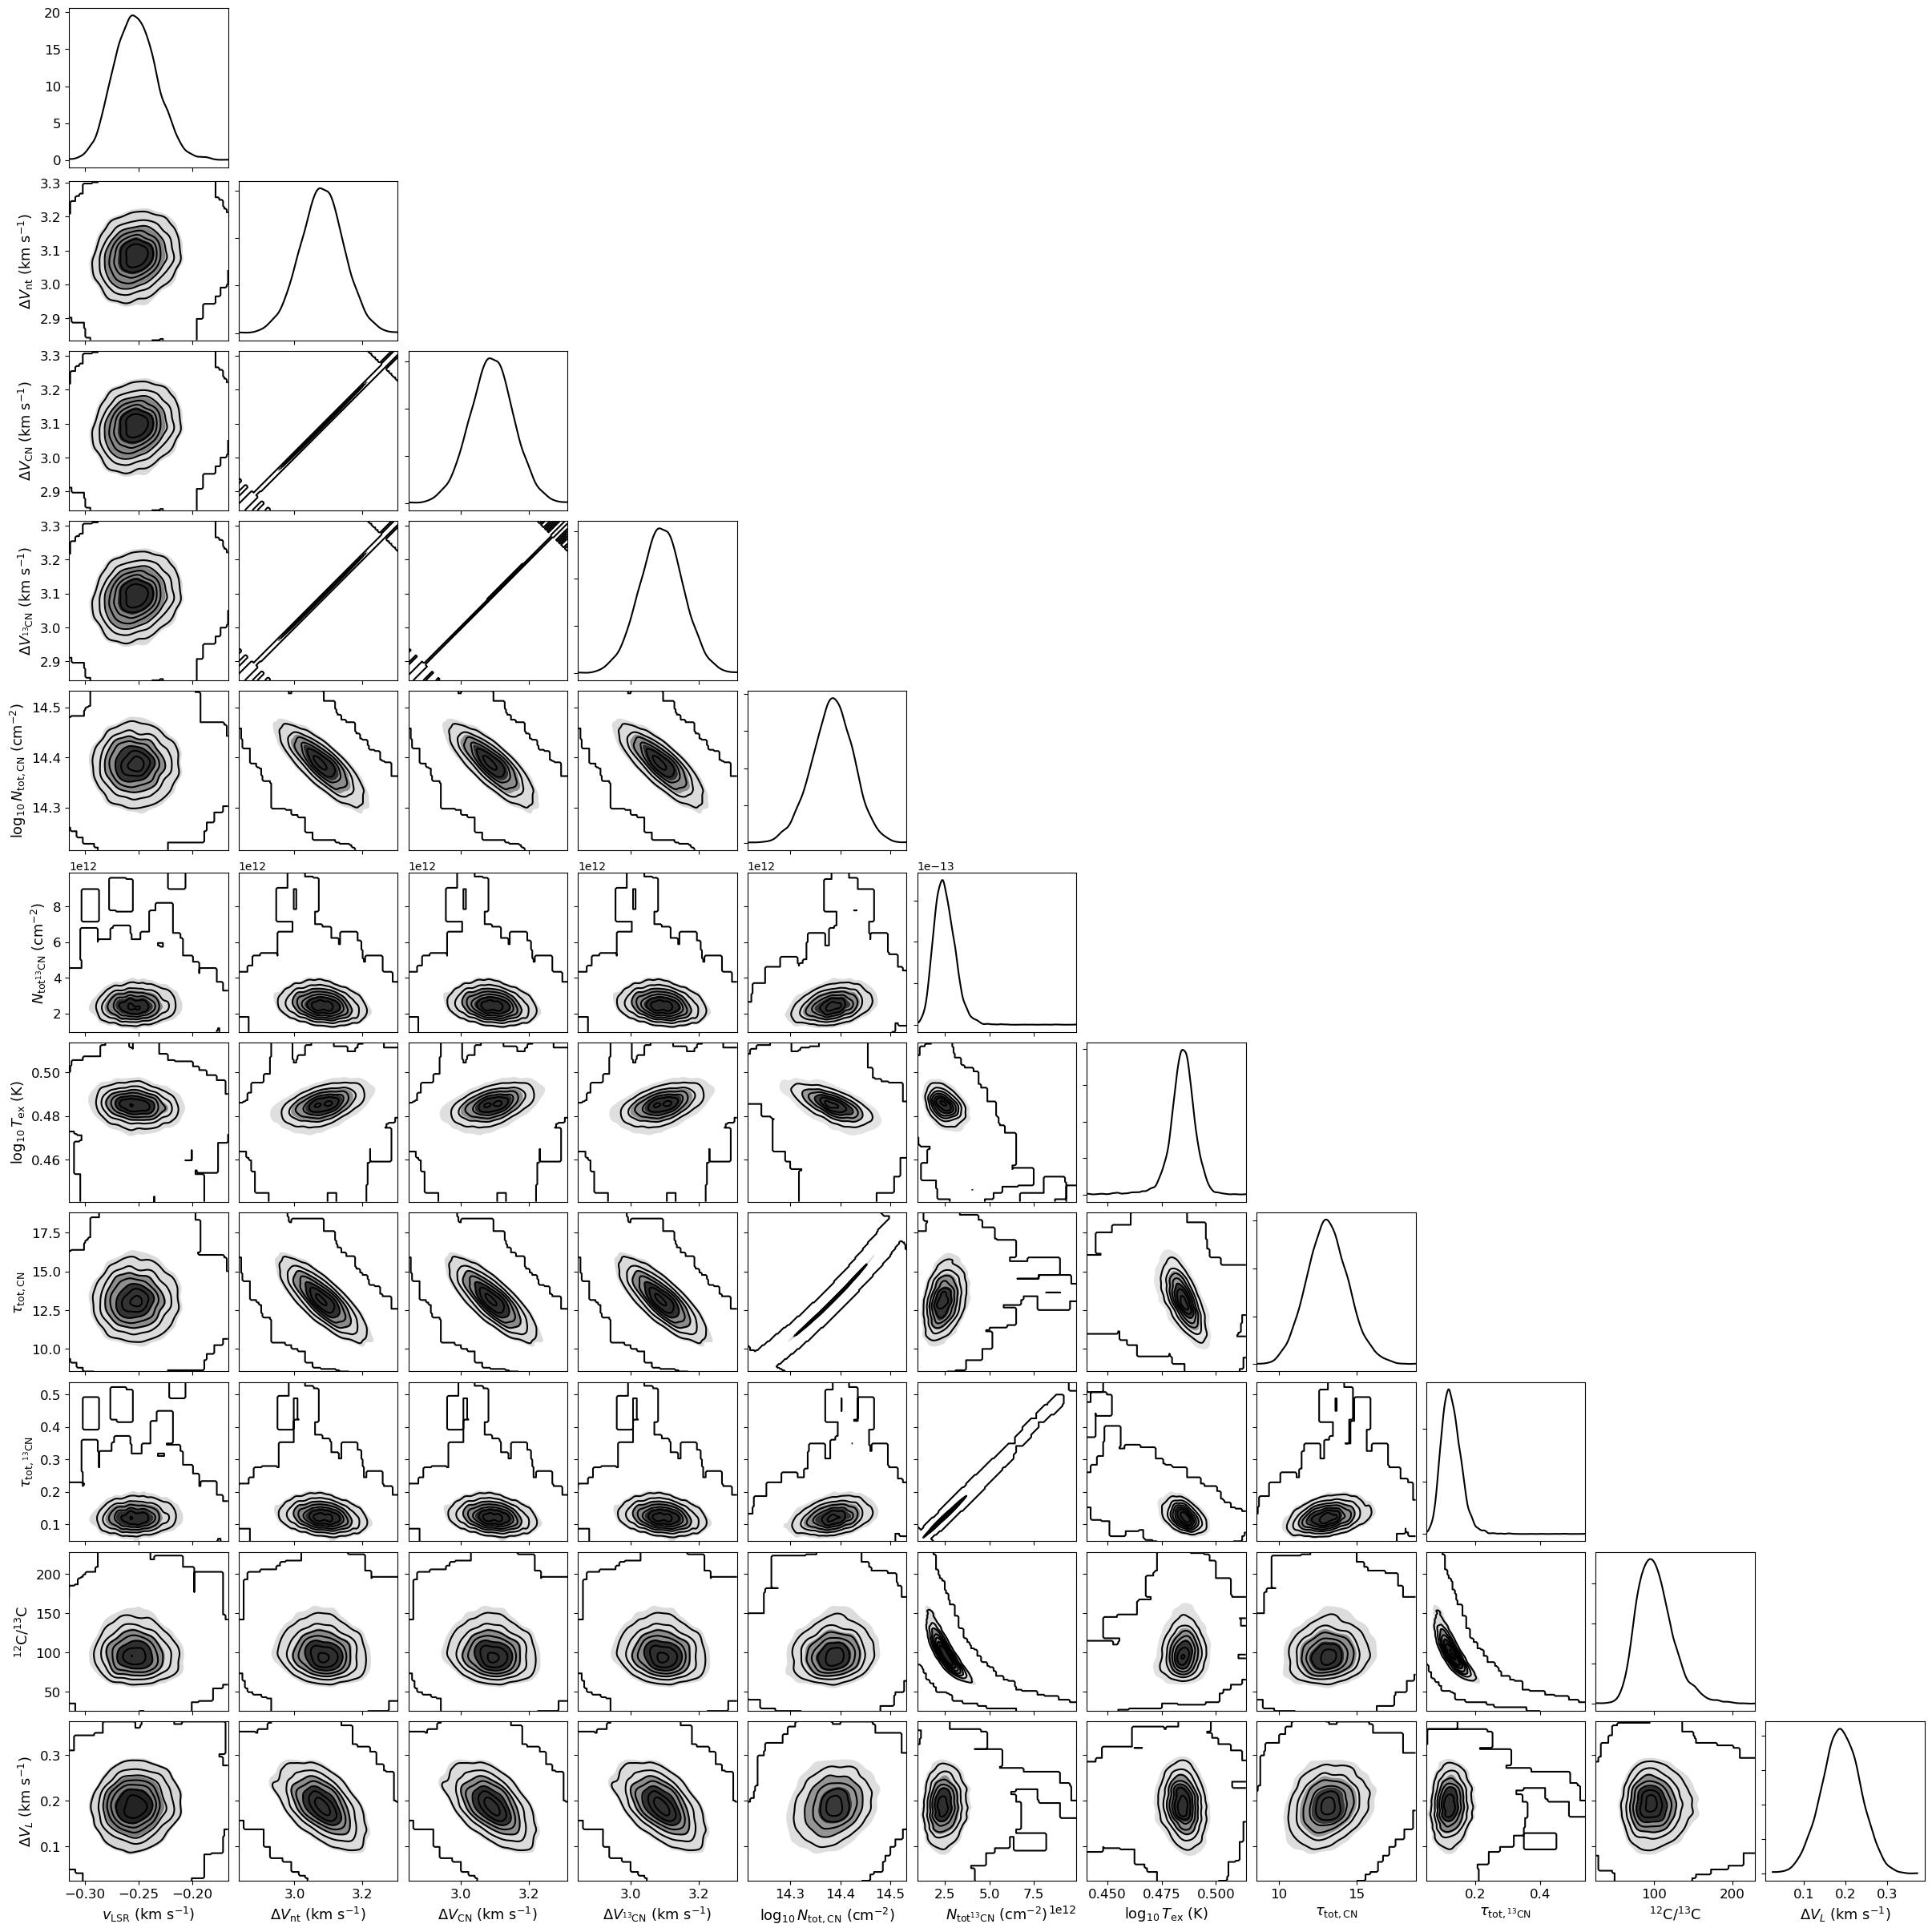

In [59]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [60]:
var_names = model.cloud_deterministics + model.baseline_freeRVs + model.hyper_freeRVs + model.hyper_deterministics + ["ratio_12C_13C", "ratio_12C_13C_total"]
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
display(point_stats)

mean            sd       hdi_16%  \
velocity[0]              -8.080000e-01  1.900000e-02 -8.250000e-01   
velocity[1]              -2.530000e-01  2.000000e-02 -2.740000e-01   
fwhm_thermal_12CN[0]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]        1.567000e+00  7.500000e-02  1.488000e+00   
fwhm_nonthermal[1]        3.082000e+00  6.500000e-02  3.017000e+00   
fwhm_12CN[0]              1.585000e+00  7.400000e-02  1.507000e+00   
fwhm_12CN[1]              3.091000e+00  6.400000e-02  3.026000e+00   
fwhm_13CN[0]              1.584000e+00  7.400000e-02  1.506000e+00   
fwhm_13CN[1]              3.090000e+00  6.400000e-02  3.026000e+00   
log10_N_12CN[0]           1.290400e+01  1.220000e-01  1.277700e+01   
log10_N_12CN[1]           1.438400e+01  4.200000e-02  1.434800e+01   
N_13CN[0]                 1.455784e+11  6.921605e+10  6.769610e+10   
N_13CN[1]                 2.511788e+12  6.236147e+11  1.774565e+12   
log10_Tex_ul[0]           6.940000e-01  8.600000e-02  5.920000e-01   
log10_Tex_ul[1]           4.840000e-01  6.000000e-03  4.800000e-01   
Tex_12CN[113123.3687, 0]  4.517000e+00  2.439000e+00  3.488000e+00   
Tex_12CN[113123.3687, 1]  3.088000e+00  3.300000e-02  3.050000e+00   
Tex_12CN[113144.19, 0]    4.560000e+00  2.625000e+00  3.580000e+00   
Tex_12CN[113144.19, 1]    3.084000e+00  3.000000e-02  3.054000e+00   
Tex_12CN[113170.535, 0]   5.282000e+00  3.415000e+00  3.871000e+00   
Tex_12CN[113170.535, 1]   3.062000e+00  2.800000e-02  3.032000e+00   
Tex_12CN[113191.325, 0]   5.287000e+00  1.923000e+00  3.843000e+00   
Tex_12CN[113191.325, 1]   3.058000e+00  2.600000e-02  3.030000e+00   
Tex_12CN[113488.142, 0]   4.619000e+00  2.739000e+00  3.611000e+00   
Tex_12CN[113488.142, 1]   3.031000e+00  2.700000e-02  3.003000e+00   
Tex_12CN[113490.985, 0]   7.429000e+00  2.154400e+01  4.574000e+00   
Tex_12CN[113490.985, 1]   3.084000e+00  1.900000e-02  3.065000e+00   
Tex_12CN[113499.643, 0]   4.366000e+00  1.381000e+00  3.469000e+00   
Tex_12CN[113499.643, 1]   3.025000e+00  2.700000e-02  2.998000e+00   
Tex_12CN[113508.934, 0]   4.737000e+00  1.465000e+00  3.665000e+00   
Tex_12CN[113508.934, 1]   3.028000e+00  2.500000e-02  3.000000e+00   
Tex_12CN[113520.4215, 0]  4.438000e+00  9.940000e-01  3.450000e+00   
Tex_12CN[113520.4215, 1]  3.021000e+00  2.700000e-02  2.993000e+00   
tau_12CN[113123.3687, 0]  4.000000e-03  2.000000e-03  2.000000e-03   
tau_12CN[113123.3687, 1]  1.580000e-01  1.700000e-02  1.420000e-01   
tau_12CN[113144.19, 0]    2.900000e-02  1.300000e-02  1.300000e-02   
tau_12CN[113144.19, 1]    1.296000e+00  1.340000e-01  1.164000e+00   
tau_12CN[113170.535, 0]   2.700000e-02  1.300000e-02  1.200000e-02   
tau_12CN[113170.535, 1]   1.266000e+00  1.320000e-01  1.140000e+00   
tau_12CN[113191.325, 0]   3.500000e-02  1.700000e-02  1.600000e-02   
tau_12CN[113191.325, 1]   1.648000e+00  1.700000e-01  1.480000e+00   
tau_12CN[113488.142, 0]   3.700000e-02  1.700000e-02  1.700000e-02   
tau_12CN[113488.142, 1]   1.655000e+00  1.720000e-01  1.494000e+00   
tau_12CN[113490.985, 0]   8.100000e-02  4.300000e-02  3.000000e-02   
tau_12CN[113490.985, 1]   4.380000e+00  4.470000e-01  3.934000e+00   
tau_12CN[113499.643, 0]   3.000000e-02  1.300000e-02  1.300000e-02   
tau_12CN[113499.643, 1]   1.307000e+00  1.360000e-01  1.178000e+00   
tau_12CN[113508.934, 0]   2.800000e-02  1.300000e-02  1.200000e-02   
tau_12CN[113508.934, 1]   1.280000e+00  1.320000e-01  1.149000e+00   
tau_12CN[113520.4215, 0]  4.000000e-03  2.000000e-03  2.000000e-03   
tau_12CN[113520.4215, 1]  1.600000e-01  1.600000e-02  1.440000e-01   
tau_total_12CN[0]         2.760000e-01  1.320000e-01  1.150000e-01   
tau_total_12CN[1]         1.315000e+01  1.354000e+00  1.186400e+01   
TR_12CN[113123.3687, 0]   2.353000e+00  2.40

## Assumption about 13CN Excitation Temperature
There is no evidence for CTEX in the 13CN data, and we are unable to constrain the excitation temperature of 13CN because we only detect the brightest transitions. Here we relax the 13CN CTEX assumption and instead assume that it suffers from hyperfine anomalies the same as 12CN.

In [61]:
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.50, 0.25], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.6, 0.15], # mean and width of excitation temperature prior (K)
    assume_CTEX_12CN = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    assume_CTEX_13CN = True, # assume CTEX for 13CN
    fix_log10_Tkin = 1.5, # kinetic temperature is fixed (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, 13CN, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tex_ul_norm, ratio_12C_13C, velocity_norm, weights_12CN]


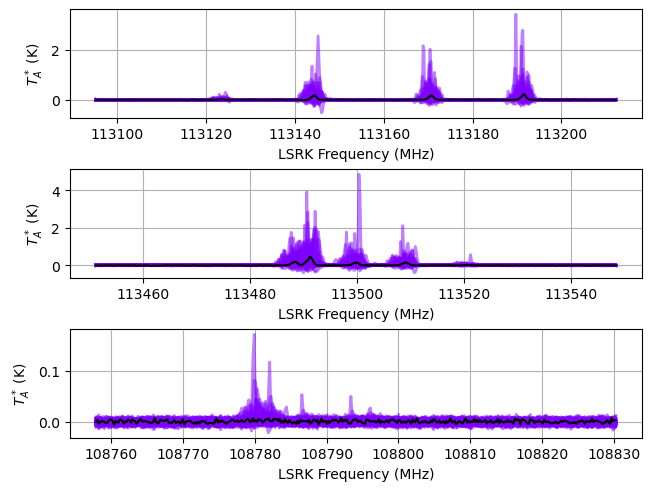

In [62]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [63]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 15,503


Output()

Runtime: 1.15 minutes


Sampling: [12CN-1, 12CN-2, 13CN]


Output()

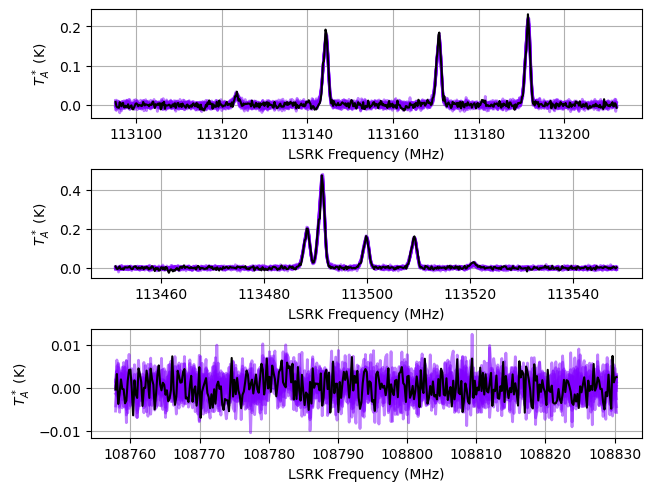

In [64]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [65]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 15,503
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C, log10_Tex_ul_norm, LTE_precision, weights_12CN]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3222 seconds.


Adding log-likelihood to trace


Output()

There were 1 divergences in converged chains.
Runtime: 55.52 minutes


In [66]:
model.solve(kl_div_threshold=0.1)

GMM found 2 unique solutions
Solution 0: chains [0, 2, 3, 4, 5, 6]
Solution 1: chains [1, 7]


In [67]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0, 1]


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
baseline_12CN-1_norm[0]  -1.810000e-01  4.200000e-02 -2.590000e-01   
baseline_12CN-2_norm[0]  -3.450000e-01  5.000000e-02 -4.370000e-01   
baseline_13CN_norm[0]     8.000000e-03  5.300000e-02 -8.800000e-02   
velocity_norm[0]         -2.690000e-01  6.000000e-03 -2.820000e-01   
velocity_norm[1]         -8.400000e-02  7.000000e-03 -9.600000e-02   
log10_N_12CN_norm[0]     -2.382000e+00  4.890000e-01 -3.295000e+00   
log10_N_12CN_norm[1]      3.536000e+00  1.680000e-01  3.224000e+00   
log10_Tex_ul_norm[0]      6.270000e-01  5.710000e-01 -3.460000e-01   
log10_Tex_ul_norm[1]     -7.710000e-01  4.200000e-02 -8.460000e-01   
fwhm_nonthermal_norm[0]   1.567000e+00  7.500000e-02  1.422000e+00   
fwhm_nonthermal_norm[1]   3.082000e+00  6.500000e-02  2.964000e+00   
fwhm_L_norm               1.890000e-01  4.700000e-02  1.010000e-01   
ratio_12C_13C[0]          6.556300e+01  2.520900e+01  2.604000e+01   
ratio_12C_13C[1]          1.018490e+02  2.366400e+01  6.081000e+01   
LTE_precision[0]          6.000000e-03  4.000000e-03  1.000000e-03   
LTE_precision[1]          0.000000e+00  0.000000e+00  0.000000e+00   
weights_12CN[0, 0 0 1 1]  1.650000e-01  2.000000e-02  1.280000e-01   
weights_12CN[0, 0 0 1 2]  3.250000e-01  3.600000e-02  2.560000e-01   
weights_12CN[0, 1 0 1 1]  4.700000e-02  5.000000e-03  3.800000e-02   
weights_12CN[0, 1 0 1 2]  1.100000e-01  1.200000e-02  9.000000e-02   
weights_12CN[0, 1 0 2 1]  4.600000e-02  5.000000e-03  3.600000e-02   
weights_12CN[0, 1 0 2 2]  9.800000e-02  9.000000e-03  8.200000e-02   
weights_12CN[0, 1 0 2 3]  2.090000e-01  2.500000e-02  1.660000e-01   
weights_12CN[1, 0 0 1 1]  2.210000e-01  1.000000e-03  2.180000e-01   
weights_12CN[1, 0 0 1 2]  4.430000e-01  2.000000e-03  4.390000e-01   
weights_12CN[1, 1 0 1 1]  3.800000e-02  1.000000e-03  3.700000e-02   
weights_12CN[1, 1 0 1 2]  7.500000e-02  1.000000e-03  7.400000e-02   
weights_12CN[1, 1 0 2 1]  3.600000e-02  0.000000e+00  3.600000e-02   
weights_12CN[1, 1 0 2 2]  7.300000e-02  1.000000e-03  7.200000e-02   
weights_12CN[1, 1 0 2 3]  1.140000e-01  1.000000e-03  1.120000e-01   
velocity[0]              -8.080000e-01  1.900000e-02 -8.460000e-01   
velocity[1]              -2.530000e-01  2.000000e-02 -2.880000e-01   
fwhm_thermal_12CN[0]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]        1.567000e+00  7.500000e-02  1.422000e+00   
fwhm_nonthermal[1]        3.082000e+00  6.500000e-02  2.964000e+00   
fwhm_12CN[0]              1.585000e+00  7.400000e-02  1.441000e+00   
fwhm_12CN[1]              3.091000e+00  6.400000e-02  2.973000e+00   
fwhm_13CN[0]              1.584000e+00  7.400000e-02  1.440000e+00   
fwhm_13CN[1]              3.090000e+00  6.400000e-02  2.973000e+00   
fwhm_L                    1.890000e-01  4.700000e-02  1.010000e-01   
log10_N_12CN[0]           1.290400e+01  1.220000e-01  1.267600e+01   
log10_N_12CN[1]           1.438400e+01  4.200000e-02  1.430600e+01   
N_13CN[0]                 1.455784e+11  6.921605e+10  4.240221e+10   
N_13CN[1]                 2.511788e+12  6.236147e+11  1.520469e+12   
log10_Tex_ul[0]           6.940000e-01  8.600000e-02  5.480000e-01   
log10_Tex_ul[1]           4.840000e-01  6.000000e-03  4.730000e-01   
Tex_12CN[113123.3687, 0]  4.517000e+00  2.439000e+00  3.233000e+00   
Tex_12CN[113123.3687, 1]  3.088000e+00  3.300000e-02  3.028000e+00   
Tex_12CN[113144.19, 0]    4.560000e+00  2.625000e+00  3.352000e+00   
Tex_12CN[113144.19, 1]    3.084000e+00  3.000000e-02  3.027000e+00   
Tex_12CN[113170.535, 0]   5.282000e+00  3.415000e+00  3.547000e+00   
Tex_12CN[113170.535, 1]   3.062000e+00  2.800000e-02  3.014000e+00   
Tex_12CN[113191.325, 0]   5.287000e+00  1.923000e+00  3.570000e+00   
Tex_12CN[113191.325, 1]   3.058000e+00  2.60

In [73]:
pm.summary(model.trace.solution_1)

/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
baseline_12CN-1_norm[0]  -1.870000e-01  4.500000e-02 -2.690000e-01   
baseline_12CN-2_norm[0]  -3.540000e-01  5.000000e-02 -4.440000e-01   
baseline_13CN_norm[0]     9.000000e-03  5.200000e-02 -9.500000e-02   
velocity_norm[0]         -3.520000e-01  7.000000e-03 -3.650000e-01   
velocity_norm[1]          1.900000e-01  1.100000e-02  1.700000e-01   
log10_N_12CN_norm[0]     -8.230000e-01  2.840000e-01 -1.326000e+00   
log10_N_12CN_norm[1]      3.773000e+00  2.320000e-01  3.323000e+00   
log10_Tex_ul_norm[0]      1.298000e+00  5.300000e-01  3.390000e-01   
log10_Tex_ul_norm[1]     -9.470000e-01  5.900000e-02 -1.067000e+00   
fwhm_nonthermal_norm[0]   2.333000e+00  5.000000e-02  2.242000e+00   
fwhm_nonthermal_norm[1]   1.963000e+00  1.200000e-01  1.725000e+00   
fwhm_L_norm               3.070000e-01  4.000000e-02  2.340000e-01   
ratio_12C_13C[0]          7.184200e+01  2.189200e+01  3.831600e+01   
ratio_12C_13C[1]          9.424200e+01  2.967200e+01  3.996300e+01   
LTE_precision[0]          1.000000e-03  2.000000e-03  0.000000e+00   
LTE_precision[1]          0.000000e+00  1.000000e-03  0.000000e+00   
weights_12CN[0, 0 0 1 1]  1.440000e-01  1.400000e-02  1.200000e-01   
weights_12CN[0, 0 0 1 2]  2.970000e-01  2.500000e-02  2.510000e-01   
weights_12CN[0, 1 0 1 1]  6.600000e-02  5.000000e-03  5.600000e-02   
weights_12CN[0, 1 0 1 2]  1.320000e-01  1.000000e-02  1.130000e-01   
weights_12CN[0, 1 0 2 1]  6.100000e-02  5.000000e-03  5.200000e-02   
weights_12CN[0, 1 0 2 2]  1.230000e-01  9.000000e-03  1.070000e-01   
weights_12CN[0, 1 0 2 3]  1.760000e-01  1.000000e-02  1.590000e-01   
weights_12CN[1, 0 0 1 1]  2.290000e-01  1.000000e-03  2.270000e-01   
weights_12CN[1, 0 0 1 2]  4.550000e-01  1.000000e-03  4.530000e-01   
weights_12CN[1, 1 0 1 1]  3.500000e-02  0.000000e+00  3.500000e-02   
weights_12CN[1, 1 0 1 2]  7.000000e-02  1.000000e-03  6.900000e-02   
weights_12CN[1, 1 0 2 1]  3.400000e-02  0.000000e+00  3.400000e-02   
weights_12CN[1, 1 0 2 2]  6.800000e-02  0.000000e+00  6.700000e-02   
weights_12CN[1, 1 0 2 3]  1.090000e-01  1.000000e-03  1.080000e-01   
velocity[0]              -1.056000e+00  2.200000e-02 -1.096000e+00   
velocity[1]               5.690000e-01  3.400000e-02  5.090000e-01   
fwhm_thermal_12CN[0]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]        2.333000e+00  5.000000e-02  2.242000e+00   
fwhm_nonthermal[1]        1.963000e+00  1.200000e-01  1.725000e+00   
fwhm_12CN[0]              2.345000e+00  4.900000e-02  2.255000e+00   
fwhm_12CN[1]              1.977000e+00  1.190000e-01  1.741000e+00   
fwhm_13CN[0]              2.344000e+00  4.900000e-02  2.254000e+00   
fwhm_13CN[1]              1.977000e+00  1.190000e-01  1.741000e+00   
fwhm_L                    3.070000e-01  4.000000e-02  2.340000e-01   
log10_N_12CN[0]           1.329400e+01  7.100000e-02  1.316900e+01   
log10_N_12CN[1]           1.444300e+01  5.800000e-02  1.433100e+01   
N_13CN[0]                 3.013599e+11  9.894715e+10  1.326038e+11   
N_13CN[1]                 3.350754e+12  1.550744e+12  1.345431e+12   
log10_Tex_ul[0]           7.950000e-01  8.000000e-02  6.510000e-01   
log10_Tex_ul[1]           4.580000e-01  9.000000e-03  4.400000e-01   
Tex_12CN[113123.3687, 0]  7.773000e+00  1.018800e+01  4.783000e+00   
Tex_12CN[113123.3687, 1]  2.899000e+00  2.000000e-02  2.860000e+00   
Tex_12CN[113144.19, 0]    7.073000e+00  1.796000e+00  4.679000e+00   
Tex_12CN[113144.19, 1]    2.908000e+00  1.900000e-02  2.874000e+00   
Tex_12CN[113170.535, 0]   7.708000e+00  9.989000e+00  4.662000e+00   
Tex_12CN[113170.535, 1]   2.890000e+00  1.600000e-02  2.862000e+00   
Tex_12CN[113191.325, 0]   7.045000e+00  1.784000e+00  4.770000e+00   
Tex_12CN[113191.325, 1]   2.899000e+00  1.50

Sampling: [12CN-1, 12CN-2, 13CN]


Output()

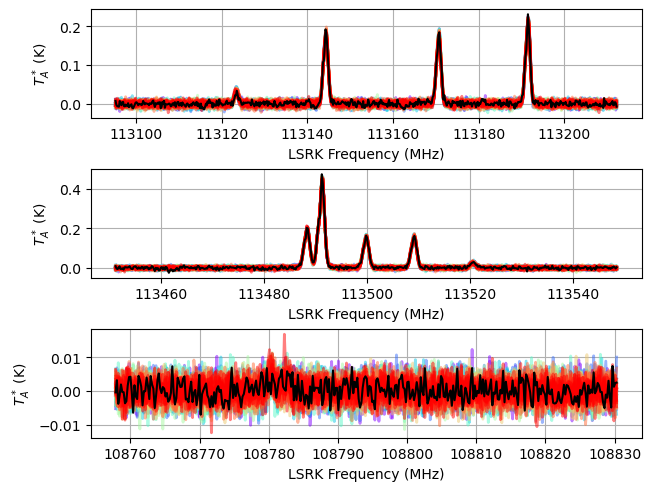

In [68]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [69]:
# 12C/13C ratio over all clouds
for solution in model.solutions:
    model.trace[f"solution_{solution}"]["ratio_12C_13C_total"] = (
        (10.0**model.trace[f"solution_{solution}"]["log10_N_12CN"]).sum(dim="cloud") / 
    model.trace[f"solution_{solution}"]["N_13CN"].sum(dim="cloud")
    )
    

In [70]:
pm.summary(model.trace.solution_0, var_names=["ratio_12C_13C_total"])

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
ratio_12C_13C_total  98.85  21.158  63.583  140.523      0.301    0.215   

                     ess_bulk  ess_tail  r_hat  
ratio_12C_13C_total    4964.0    4081.0    1.0

In [72]:
pm.summary(model.trace.solution_1, var_names=["ratio_12C_13C_total"])

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
ratio_12C_13C_total  90.823  25.847  45.223  143.349      0.656    0.464   

                     ess_bulk  ess_tail  r_hat  
ratio_12C_13C_total    1472.0     991.0    1.0

In [71]:
import pickle
with open("/staging/twenger2/wb89_380_trace_noCTEX.pkl", "wb") as f:
    pickle.dump(model.trace, f)